## Setup

Import the required libraries and initialize them:

In [1]:
#python 2 issues
# load model wont work , load weights is a workaround.
# if ros noetic and python 3 is AVAILABle  use load model instead.
# DAta augmentation (KERAS) is experimental, not retrocompatible for keras directory to trainin batches
batch_size=128
img_width=300
img_height=300
#train_data_dir ='/home/oscar/Videos/videos_to_keras_train/'
train_data_dir ='/home/roboworks/Videos/videos_to_keras_train/'


import tensorflow
from tensorflow.keras import layers , Sequential
num_classes = 73
model = Sequential([
  
  layers.Conv2D(16, 3, padding='same', activation='relu' , input_shape=(img_height, img_width,3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
      
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.load_weights('weights_ycb')
model.summary()

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,3,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [4]:
from std_srvs.srv import Empty, Trigger, TriggerRequest


In [5]:
from cv_bridge import CvBridge, CvBridgeError
import rospy
#import cv2
import ros_numpy
import numpy as np
from tmc_tabletop_segmentator.srv import TabletopSegmentation
from tmc_tabletop_segmentator.srv import TabletopSegmentationRequest
from sensor_msgs.msg import Image
from std_msgs.msg import String
import tf
import tf2_ros
import geometry_msgs.msg
from utils_notebooks import *


the rosdep view is empty: call 'sudo rosdep init' and 'rosdep update'


In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import ros_numpy
import rospy
import tf
from gazebo_ros import gazebo_interface
from sensor_msgs.msg import LaserScan, PointCloud2
from geometry_msgs.msg import Pose, Quaternion ,TransformStamped
import moveit_commander
import moveit_msgs.msg

import sys

from utils_notebooks import *
#from utils_task1 import *
import cv2
import os

# REMEMBER TO RUN MOVEIT 
# roslaunch  hsrb_moveit_config  hsrb_demo_with_controller.launch

In [7]:


cv2.__version__

## CHECK  CV VERSIONS IN CASE YOU WONT USE SURF 
## 3.3.1 is an old dependence use sys path remove if needed


'3.3.1-dev'

In [8]:
#! roslaunch  hsrb_moveit_config  hsrb_demo_with_controller.launch

In [9]:


bridge = CvBridge()
###might take some time to load all those takeshi meshes in rviz

head = moveit_commander.MoveGroupCommander('head')
arm = moveit_commander.MoveGroupCommander('arm')
whole_body = moveit_commander.MoveGroupCommander('whole_body_light')
whole_body.set_workspace([-6.0, -6.0, 6.0, 6.0])#whole_body.go(wb)


In [10]:
def rot_to_euler(R):
    import sys
    import math as m
    tol = sys.float_info.epsilon * 10

    if abs(R.item(0,0))< tol and abs(R.item(1,0)) < tol:
       eul1 = 0
       eul2 = m.atan2(-R.item(2,0), R.item(0,0))
       eul3 = m.atan2(-R.item(1,2), R.item(1,1))
    else:   
       eul1 = m.atan2(R.item(1,0),R.item(0,0))
       sp = m.sin(eul1)
       cp = m.cos(eul1)
       eul2 = m.atan2(-R.item(2,0),cp*R.item(0,0)+sp*R.item(1,0))
       eul3 = m.atan2(sp*R.item(0,2)-cp*R.item(1,2),cp*R.item(1,1)-sp*R.item(0,1))

    return np.asarray((eul1,eul2,eul3))
def pca_xyz(xyz):
    quats=[]
    for i in range( len(xyz)):
        pca= PCA(n_components=3).fit(xyz[i])
        vec0= pca.components_[0,:]
        vec1= pca.components_[1,:]
        vec2= pca.components_[2,:]
        R=pca.components_
        euler=rot_to_euler(R)
        quats.append(tf.transformations.quaternion_from_euler(euler[0],euler[1],euler[2]))
    return quats

In [11]:
def rot_to_euler(R):
    import sys
    tol = sys.float_info.epsilon * 10

    if abs(R.item(0,0))< tol and abs(R.item(1,0)) < tol:
       eul1 = 0
       eul2 = m.atan2(-R.item(2,0), R.item(0,0))
       eul3 = m.atan2(-R.item(1,2), R.item(1,1))
    else:   
       eul1 = m.atan2(R.item(1,0),R.item(0,0))
       sp = m.sin(eul1)
       cp = m.cos(eul1)
       eul2 = m.atan2(-R.item(2,0),cp*R.item(0,0)+sp*R.item(1,0))
       eul3 = m.atan2(sp*R.item(0,2)-cp*R.item(1,2),cp*R.item(1,1)-sp*R.item(0,1))

    return np.asarray((eul1,eul2,eul3))
def pca_xyz(xyz):
    quats=[]
    for i in range( len(xyz)):
        pca= PCA(n_components=3).fit(xyz[i])
        vec0= pca.components_[0,:]
        vec1= pca.components_[1,:]
        vec2= pca.components_[2,:]
        R=pca.components_
        euler=rot_to_euler(R)
        quats.append(tf.transformations.quaternion_from_euler(euler[0],euler[1],euler[2]))
    return quats
def static_tf_publish(cents, quaternions=[],label=''):
    if (len(quaternions))==0:
        quats=np.zeros((len(cents),4)) 
        quats[:,3]=1
        #print quats
    else:
        quats=np.asarray(quaternions)
        #print quats
    for  i ,cent  in enumerate(cents):
        x,y,z=cent
        if np.isnan(x) or np.isnan(y) or np.isnan(z):
            print('nan , rejected')
        else:
            #### first place a dissolving tf wrt head sensor  in centroids

            broadcaster.sendTransform((x,y,z),(0,0,0,1), rospy.Time.now(), 'Object'+str(i),"head_rgbd_sensor_link")
            rospy.sleep(.2)
            
            #### then place each centr wrt map
            xyz_map,cent_quat= listener.lookupTransform('/map', 'Object'+str(i),rospy.Time(0))
            map_euler=tf.transformations.euler_from_quaternion(cent_quat)
            rospy.sleep(.2)
            static_transformStamped = TransformStamped()

            ##FIXING TF TO MAP ( ODOM REALLY)    
            #tf_broadcaster1.sendTransform( (xyz[0],xyz[1],xyz[2]),tf.transformations.quaternion_from_euler(0, 0, 0), rospy.Time.now(), "obj"+str(ind), "head_rgbd_sensor_link")
            ## Finally boiradcast a static tf  in cents and with quaternion found  in pca
            if xyz_map[-1] <.2:
                static_transformStamped.header.stamp = rospy.Time.now()
                static_transformStamped.header.frame_id = "map"
                static_transformStamped.child_frame_id = "Floor_Object"+str(i)+label 
                static_transformStamped.transform.translation.x = float(xyz_map[0])
                static_transformStamped.transform.translation.y = float(xyz_map[1])
                static_transformStamped.transform.translation.z = float(xyz_map[2])
                #quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
                static_transformStamped.transform.rotation.x = quats [i,0]#-quat[0]#trans.transform.rotation.x
                static_transformStamped.transform.rotation.y = quats [i,1]#-quat[1]#trans.transform.rotation.y
                static_transformStamped.transform.rotation.z = quats [i,2]#-quat[2]#trans.transform.rotation.z
                static_transformStamped.transform.rotation.w = quats [i,3]#-quat[3]#trans.transform.rotation.w


                tf_static_broadcaster.sendTransform(static_transformStamped)
                print ('images[]',i)
            if    (xyz_map[-1] >.4)and (xyz_map[-1] <.5):
                static_transformStamped.header.stamp = rospy.Time.now()
                static_transformStamped.header.frame_id = "map"
                static_transformStamped.child_frame_id = "Table_Object"+str(i)+label 
                static_transformStamped.transform.translation.x = float(xyz_map[0])
                static_transformStamped.transform.translation.y = float(xyz_map[1])
                static_transformStamped.transform.translation.z = float(xyz_map[2])
                #quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
                static_transformStamped.transform.rotation.x = quats [i,0]#-quat[0]#trans.transform.rotation.x
                static_transformStamped.transform.rotation.y = quats [i,1]#-quat[1]#trans.transform.rotation.y
                static_transformStamped.transform.rotation.z = quats [i,2]#-quat[2]#trans.transform.rotation.z
                static_transformStamped.transform.rotation.w = quats [i,3]#-quat[3]#trans.transform.rotation.w


                tf_static_broadcaster.sendTransform(static_transformStamped)
                print ('images[]',i)
    return True


In [12]:
#!python /home/oscar/Codes/catkin_mio_ws/src/hsrb_samples/hsrb_vision_samples/src/hsrb_vision_samples/execute_tabletop_segmentation.py

In [13]:
#! python /home/oscar/Codes/catkin_mio_ws/src/hsrb_samples/hsrb_vision_samples/src/hsrb_vision_samples/execute_tabletop_segmentation_backup.py



In [14]:

rospy.init_node("recognition")


In [15]:
def pose_2_np(wp_p):
   
    return np.asarray((wp_p.pose.position.x,wp_p.pose.position.y,wp_p.pose.position.z)) , np.asarray((wp_p.pose.orientation.w,wp_p.pose.orientation.x,wp_p.pose.orientation.y, wp_p.pose.orientation.z)) 
def np_2_pose(position,orientation):
    wb_p= geometry_msgs.msg.PoseStamped()
    
    wb_p.pose.position.x= position[0]
    wb_p.pose.position.y= position[1]
    wb_p.pose.position.z= position[2]
    wb_p.pose.orientation.w= orientation[0]
    wb_p.pose.orientation.x= orientation[1]
    wb_p.pose.orientation.y= orientation[2]
    wb_p.pose.orientation.z= orientation[3]
    return wb_p

In [16]:
rgbd = RGBD()
#a listener xtion rgbd listener class , (check utils for methods )
# TF is one of the most powerfull underated Ros tools, I recomend to understand it and use it as often as possible.
listener = tf.TransformListener()
broadcaster= tf.TransformBroadcaster()
tf_static_broadcaster= tf2_ros.StaticTransformBroadcaster()


In [17]:
def gaze_point(x,y,z):
    
    
    
    head_pose = head.get_current_joint_values()
    head_pose[0]=0.0
    head_pose[1]=0.0
    head.set_joint_value_target(head_pose)
    head.go()
    
    trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0)) #
    
    arm_pose=arm.get_current_joint_values()
    arm_pose[0]=.1
    arm_pose[1]= -0.3
    arm.set_joint_value_target(arm_pose)
    arm.go()
    
    e =tf.transformations.euler_from_quaternion(rot)
    print('i am at',trans,np.rad2deg(e)[2])
    print('gaze goal',x,y,z)
    #tf.transformations.euler_from_quaternion(rot)


    x_rob,y_rob,z_rob,th_rob= trans[0], trans[1] ,trans[2] ,  e[2]


    D_x=x_rob-x
    D_y=y_rob-y
    D_z=z_rob-z

    D_th= np.arctan2(D_y,D_x)
    print('relative to robot',(D_x,D_y,np.rad2deg(D_th)))

    pan_correct= (- th_rob + D_th + np.pi) % (2*np.pi)

    if(pan_correct > np.pi):
        pan_correct=-2*np.pi+pan_correct
    if(pan_correct < -np.pi):
        pan_correct=2*np.pi+pan_correct

    if ((pan_correct) > .5 * np.pi):
        print ('Exorcist alert')
        pan_correct=.5*np.pi
    head_pose[0]=pan_correct
    tilt_correct=np.arctan2(D_z,np.linalg.norm((D_x,D_y)))

    head_pose [1]=-tilt_correct
    
    
    
    head.set_joint_value_target(head_pose)
    succ=head.go()
    return succ

In [18]:
clear_octo_client = rospy.ServiceProxy('/clear_octomap', Empty)

clear_octo_client.wait_for_service(timeout=1.0)


In [19]:
# initialize ROS publisher
pub = rospy.Publisher('goal', PoseStamped, queue_size=10)
goal = MoveBaseGoal()
navclient = actionlib.SimpleActionClient('/move_base/move', MoveBaseAction)
    
# wait to establish connection between the navigation interface
# move_base and navigation_log_recorder node
def move_base(goal_x,goal_y,goal_yaw,time_out=10):
    pose = PoseStamped()
    pose.header.stamp = rospy.Time.now()
    pose.header.frame_id = "map"
    pose.pose.position = Point(goal_x, goal_y, 0)
    quat = tf.transformations.quaternion_from_euler(0, 0, goal_yaw)
    pose.pose.orientation = Quaternion(*quat)


    # create a MOVE BASE GOAL
    goal = MoveBaseGoal()
    goal.target_pose = pose

    # send message to the action server
    navclient.send_goal(goal)

    # wait for the action server to complete the order
    navclient.wait_for_result(timeout=rospy.Duration(time_out))

    # print result of navigation
    action_state = navclient.get_state()
    return navclient.get_state()

In [20]:
def seg_pca(lower=2000,higher=50000,reg_ly=0,reg_hy=1000,plt_images=False): 
    image= rgbd.get_h_image()
    iimmg= rgbd.get_image()
    points_data= rgbd.get_points()
    values=image.reshape((-1,3))
    values= np.float32(values)
    criteria= (  cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER  ,1000,0.1)
    k=6
    _ , labels , cc =cv2.kmeans(values , k ,None,criteria,30,cv2.KMEANS_RANDOM_CENTERS)
    cc=np.uint8(cc)
    segmented_image= cc[labels.flatten()]
    segmented_image=segmented_image.reshape(image.shape)
    th3 = cv2.adaptiveThreshold(segmented_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    kernel = np.ones((5,5),np.uint8)
    im4=cv2.erode(th3,kernel,iterations=4)
    plane_mask=points_data['z']
    cv2_img=plane_mask.astype('uint8')
    img=im4
    _,contours, hierarchy = cv2.findContours(im4.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    points=[]
    images=[]
    for i, contour in enumerate(contours):
        
        area = cv2.contourArea(contour)

        if area > lower and area < higher :
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            
    
            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this
            long_rect=np.max((boundRect[2:3]))
            #image_aux= iimmg[boundRect[1]:boundRect[1]+boundRect[3],boundRect[0]:boundRect[0]+boundRect[2]]
            image_aux= iimmg[boundRect[1]:boundRect[1]+long_rect,boundRect[0]:boundRect[0]+ long_rect]
            #image_square = iimmg[boundRect[1]:boundRect[1]+np.max(boundRect[3],boundRect[2]),boundRect[0]:boundRect[0]+np.max(boundRect[3],boundRect[2])]
            images.append(image_aux)
            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            if (cY > reg_ly and cY < reg_hy  ):
                
                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                print ('cX,cY',cX,cY)
                xyz=[]


                for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                        aux=(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
                        if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                            'reject point'
                        else:
                            xyz.append(aux)

                xyz=np.asarray(xyz)
                cent=xyz.mean(axis=0)
                cents.append(cent)
                print (cent)
                points.append(xyz)
            else:
                print ('cent out of region... rejected')
    sub_plt=0
    if plt_images:
        for image in images:

            sub_plt+=1
            ax = plt.subplot(5, 5, sub_plt )

            plt.imshow(image)
            plt.axis("off")

    cents=np.asarray(cents)
    ### returns centroids found and a group of 3d coordinates that conform the centroid
    return(cents,np.asarray(points), images)

('cX,cY', 202, 448)
[-0.52748924  0.9823845   2.6325123 ]
('cX,cY', 544, 436)
[0.61855084 0.5362832  1.5012544 ]


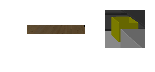

In [21]:
_,_,_=seg_pca(plt_images=True)

In [22]:
service_client = rospy.ServiceProxy('/tabletop_segmentator_node/execute', TabletopSegmentation)
service_client.wait_for_service(timeout=1.0)


In [23]:
def res_to_cents(res, plt_images=False):
    objs_depth_centroids=[]
    xyz=[]
    images=[]
    for i in range (len(res.segmented_objects_array.table_objects_array	)):
        print ( 'Plane',i,'has', len(res.segmented_objects_array.table_objects_array[i].depth_image_array), 'objects')
        for j in range (len(res.segmented_objects_array.table_objects_array[i].points_array)):
            cv2_img_depth = bridge.imgmsg_to_cv2(res.segmented_objects_array.table_objects_array[i].depth_image_array[0] )
            cv2_img = bridge.imgmsg_to_cv2(res.segmented_objects_array.table_objects_array[i].rgb_image_array[j],"rgb8" )
            pc= ros_numpy.numpify (res.segmented_objects_array.table_objects_array[i].points_array[j])
            points=np.zeros((pc.shape[0],3))
            points[:,0]=pc['x']
            points[:,1]=pc['y']
            points[:,2]=pc['z']

            points_mean=np.mean(points,axis=0)
            if np.isnan(points_mean).max():
                print('nan reject')
            else:

                objs_depth_centroids.append(points_mean)
                xyz.append(points)
                images.append(cv2_img)

    print objs_depth_centroids

    #lets publish a tf to this centroids ( lot of false positives) !!!!
    sub_plt=0
    if plt_images:
        for image in images:

            sub_plt+=1
            ax = plt.subplot(5, 5, sub_plt )

            plt.imshow(image)
            plt.axis("off")
    return(np.asarray(objs_depth_centroids), np.asarray(xyz),images)
        

In [24]:
move_base(1.25,1.3,0.5*np.pi)

1

In [25]:
arm.set_named_target('go')
arm.go()
head_val=head.get_current_joint_values()
#head_val[0]=np.deg2rad(0)
head_val[1]=np.deg2rad(-45)

head.go(head_val)
#If head didnt move, MOVE IT isnt running  properly

True

In [24]:

#define a tabletop segmentation request.
# Play with these parameters


req = TabletopSegmentationRequest()
req.crop_enabled = True  # limit the processing area
req.crop_x_max = 0.7     # X coordinate maximum value in the area [m]
req.crop_x_min = -0.7    # X coordinate minimum value in the area [m]
req.crop_y_max = 1.0     # Y coordinate maximum value in the area [m]
req.crop_y_min = -1.0    # Y coordinate minimum value in the area [m]
req.crop_z_max = 1.0     # Z coordinate maximum value in the area [m]
req.crop_z_min = -1.0     # Z coordinate minimum value in the area [m]
req.cluster_z_max = 3  # maximum height value of cluster on table [m]
req.cluster_z_min = 0.0  # minimum height value of cluster on table [m]
req.remove_bg = False    # remove the background of the segment image    THIS IS AN IMPORTANT PARAMETER PLEASE NOTICE



In [25]:
def gazebo_2_world(x,y):

    x_world= x+2.1
    y_world= -(y-1.2)
    return (x_world,y_world)

def world_2_gazebo(y_world , x_world):

    x= ( x_world - 2.1)
    y= (-y_world + 1.2) 
    return (x , y)

_path_model = "/home/roboworks/Codes/catkin_mio/src/tmc_wrs_gazebo_world/models"     #Catkin mio version 


objs=os.listdir(_path_model)
objs.sort()


In [26]:
objs

['person_standing',
 'training_floor',
 'training_wall',
 'trofast',
 'wrc_bin_black',
 'wrc_bin_green',
 'wrc_bookshelf',
 'wrc_container_a',
 'wrc_container_b',
 'wrc_frame',
 'wrc_ground_plane',
 'wrc_long_table',
 'wrc_stair_like_drawer',
 'wrc_tall_table',
 'wrc_tray',
 'ycb_002_master_chef_can',
 'ycb_003_cracker_box',
 'ycb_004_sugar_box',
 'ycb_005_tomato_soup_can',
 'ycb_006_mustard_bottle',
 'ycb_007_tuna_fish_can',
 'ycb_008_pudding_box',
 'ycb_009_gelatin_box',
 'ycb_010_potted_meat_can',
 'ycb_011_banana',
 'ycb_012_strawberry',
 'ycb_013_apple',
 'ycb_014_lemon',
 'ycb_015_peach',
 'ycb_016_pear',
 'ycb_017_orange',
 'ycb_018_plum',
 'ycb_019_pitcher_base',
 'ycb_021_bleach_cleanser',
 'ycb_022_windex_bottle',
 'ycb_024_bowl',
 'ycb_025_mug',
 'ycb_026_sponge',
 'ycb_027_skillet',
 'ycb_028_skillet_lid',
 'ycb_029_plate',
 'ycb_030_fork',
 'ycb_031_spoon',
 'ycb_032_knife',
 'ycb_033_spatula',
 'ycb_035_power_drill',
 'ycb_036_wood_block',
 'ycb_037_scissors',
 'ycb_038_p

In [27]:
path='/home/roboworks/Videos/videos_to_keras_train/'
obj_ind=-30
obj_name = ''.join(objs[obj_ind].split('_')[1:])
obj_name
try: 
    os.mkdir(path+obj_name) 
except OSError as error: 
    print(error)  
delete_object('spawned')

[Errno 17] File exists: '/home/roboworks/Videos/videos_to_keras_train/061foambrick'


In [28]:
move_base(1.25,1.15,np.pi)
gaze_point(1.25,1.61,.6)

('i am at', [1.3098384926520468, 1.127040544227214, 0.9670992942506129], 179.43887412447262)
('gaze goal', 1.25, 1.61, 0.6)
('relative to robot', (0.05983849265204677, -0.4829594557727861, -82.93706925514086))


True

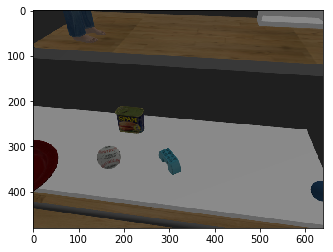

In [29]:
plt.imshow(rgbd.get_image())

In [ ]:
obj_ind=-52
x_gaz,y_gaz= world_2_gazebo(1.25,1.71)
eu_i,eu_j,eu_k = 3.1416  ,0,0
spawn_object('spawned',objs[obj_ind], x_gaz,  y_gaz,  0.45,eu_i,eu_j,eu_k )
rospy.sleep(.1)

In [ ]:

num_imgs=200
for i in range(num_imgs):
    contador=len(os.listdir(path+'/'+obj_name))

    x_gaz,y_gaz= world_2_gazebo(1.25,1.71)
    eu_i,eu_j,eu_k = 3.1416 - i*(3.1416/num_imgs) ,0,0
    spawn_object('spawned',objs[obj_ind], x_gaz,  y_gaz,  0.45,eu_i,eu_j,eu_k )
    rospy.sleep(.1)
    #res = service_client(req)
    cents,xyz, images=seg_pca(higher=25000)#res_to_cents(res)
    
    shapes_ratio=[]
    for image in images:
        print(np.abs(image.shape[0]-image.shape[1]))
        shapes_ratio.append(np.abs(image.shape[0]-image.shape[1]))
    
    if len (images)!=0:
        plt.imshow(images[np.argmin(shapes_ratio)])
        contador=len(os.listdir(path+'/'+obj_name))
        if np.min(shapes_ratio)< 10:
            cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[np.argmin(shapes_ratio)], cv2.COLOR_BGR2RGB))
    
    delete_object('spawned')

('i am at', [1.3184844497556998, 1.1344193127761133, 1.0175170931963282], 179.4377830060684)
('gaze goal', 1.25, 1.61, 0.6)
('relative to robot', (0.06848444975569978, -0.4755806872238868, -81.80563860828043))
[INFO] [1642465764.034511, 3637.732000]: Spawn: ycb_009_gelatin_box
[INFO] [1642465764.037509, 3637.732000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1642465764.040506, 3637.732000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642465764.048951, 3637.733000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642465764.279683, 3637.760000]: Spawn status: SpawnModel: Successfully spawned entity
[INFO] [1642465765.339259, 3637.860000]: Spawn: ycb_009_gelatin_box
[INFO] [1642465765.341723, 3637.860000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1642465765.343774, 3637.861000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642465765.355007, 3637.863000]: Calling service /gazebo/spawn_sdf_model
[INFO] 

[INFO] [1642465814.638754, 3643.456000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.18695809  0.37392873  1.0087281 ]
('cX,cY', 407, 308)
[0.12163759 0.09196045 0.77507794]
360
0
[INFO] [1642465817.808819, 3643.812000]: Spawn: ycb_009_gelatin_box
[INFO] [1642465817.811353, 3643.812000]: Spawn: [0.         0.         0.99306886 0.11753402]
[INFO] [1642465817.813034, 3643.812000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642465817.820655, 3643.813000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642465817.937998, 3643.820000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.18696208  0.37391096  1.0086856 ]
('cX,cY', 405, 308)
[0.12041239 0.09496067 0.76749206]
360
0
[INFO] [1642465821.303189, 3644.158000]: Spawn: ycb_009_gelatin_box
[INFO] [1642465821.305958, 3644.159000]: Spawn: [0.         0.         0.99211512 0.12532988]
[INFO] [1642465821.307718, 3644.159000]: Waiting for service /gazebo/spawn_sdf_mod

('cX,cY', 151, 456)
[-0.18694632  0.37388408  1.0086019 ]
('cX,cY', 411, 308)
[0.12918158 0.09653678 0.7779381 ]
360
0
[INFO] [1642465869.085813, 3649.561000]: Spawn: ycb_009_gelatin_box
[INFO] [1642465869.088176, 3649.561000]: Spawn: [0.         0.         0.97237065 0.23344233]
[INFO] [1642465869.091861, 3649.562000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642465869.108615, 3649.563000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642465869.375503, 3649.592000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.18694487  0.37385985  1.0085423 ]
('cX,cY', 410, 309)
[0.12423409 0.09620003 0.77504194]
360
0
[INFO] [1642465872.675912, 3649.960000]: Spawn: ycb_009_gelatin_box
[INFO] [1642465872.678916, 3649.960000]: Spawn: [0.         0.         0.97050722 0.24107205]
[INFO] [1642465872.681735, 3649.961000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642465872.690294, 3649.962000]: Calling service /gazebo/spawn_sdf_model
[INFO] [164

[INFO] [1642465920.380652, 3655.485000]: Spawn: ycb_009_gelatin_box
[INFO] [1642465920.391745, 3655.487000]: Spawn: [0.         0.         0.93819232 0.34611439]
[INFO] [1642465920.395162, 3655.488000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642465920.400484, 3655.488000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642465920.669167, 3655.517000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.1869433   0.37382993  1.0084589 ]
('cX,cY', 415, 310)
[0.13426886 0.10119152 0.7751494 ]
360
0
[INFO] [1642465923.767802, 3655.883000]: Spawn: ycb_009_gelatin_box
[INFO] [1642465923.770828, 3655.883000]: Spawn: [0.         0.         0.93544503 0.3534722 ]
[INFO] [1642465923.773008, 3655.883000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642465923.789298, 3655.886000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642465923.893821, 3655.890000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.18694438  0

[INFO] [1642465972.081624, 3661.423000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18694147  0.37379593  1.0083588 ]
('cX,cY', 417, 312)
[0.14085734 0.10182717 0.7765206 ]
360
0
[INFO] [1642465975.108606, 3661.757000]: Spawn: ycb_009_gelatin_box
[INFO] [1642465975.111898, 3661.757000]: Spawn: [0.         0.         0.88741462 0.46097211]
[INFO] [1642465975.113793, 3661.758000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642465975.132183, 3661.760000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642465975.234753, 3661.763000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.18693767  0.37377954  1.0083178 ]
('cX,cY', 418, 311)
[0.14168552 0.10119299 0.77712345]
360
0
[INFO] [1642465978.522540, 3662.150000]: Spawn: ycb_009_gelatin_box
[INFO] [1642465978.525258, 3662.150000]: Spawn: [0.         0.         0.88376682 0.46792757]
[INFO] [1642465978.528773, 3662.150000]: Waiting for service /gazebo/spawn_sdf_mod

('cX,cY', 150, 456)
[-0.1869336   0.37374055  1.0082035 ]
('cX,cY', 420, 314)
[0.14377095 0.10343117 0.7736276 ]
360
0
[INFO] [1642466026.731929, 3667.576000]: Spawn: ycb_009_gelatin_box
[INFO] [1642466026.735464, 3667.576000]: Spawn: [0.         0.         0.82708185 0.56208149]
[INFO] [1642466026.737940, 3667.576000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466026.762165, 3667.578000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466027.083124, 3667.612000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.186937    0.37376413  1.0082675 ]
('cX,cY', 420, 313)
[0.14456265 0.10346805 0.7740287 ]
360
0
[INFO] [1642466030.276130, 3667.974000]: Spawn: ycb_009_gelatin_box
[INFO] [1642466030.278878, 3667.974000]: Spawn: [0.         0.         0.8226418  0.56855999]
[INFO] [1642466030.281753, 3667.974000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466030.311372, 3667.979000]: Calling service /gazebo/spawn_sdf_model
[INFO] [164

[INFO] [1642466077.315864, 3673.237000]: Spawn: ycb_009_gelatin_box
[INFO] [1642466077.319464, 3673.238000]: Spawn: [0.         0.         0.75528312 0.65539866]
[INFO] [1642466077.320920, 3673.238000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466077.328879, 3673.239000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466077.580655, 3673.265000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18693252  0.37371624  1.0081347 ]
('cX,cY', 421, 316)
[0.14607604 0.10398237 0.7673996 ]
360
0
[INFO] [1642466080.638454, 3673.605000]: Spawn: ycb_009_gelatin_box
[INFO] [1642466080.642839, 3673.605000]: Spawn: [0.         0.         0.75011238 0.66131038]
[INFO] [1642466080.645727, 3673.606000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466080.656839, 3673.607000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466080.770004, 3673.608000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18692057  0

[INFO] [1642466128.487418, 3679.110000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18692248  0.37365404  1.0079598 ]
('cX,cY', 421, 319)
[0.14742588 0.10456453 0.76350474]
360
0
[INFO] [1642466131.666325, 3679.445000]: Spawn: ycb_009_gelatin_box
[INFO] [1642466131.670163, 3679.445000]: Spawn: [0.         0.         0.66718404 0.74489292]
[INFO] [1642466131.672048, 3679.446000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466131.690145, 3679.449000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466131.936550, 3679.477000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18691918  0.373641    1.00792   ]
('cX,cY', 421, 319)
[0.14490305 0.10431684 0.7618387 ]
360
0
[INFO] [1642466135.264087, 3679.857000]: Spawn: ycb_009_gelatin_box
[INFO] [1642466135.266996, 3679.858000]: Spawn: [0.         0.         0.66131313 0.75010995]
[INFO] [1642466135.268486, 3679.858000]: Waiting for service /gazebo/spawn_sdf_mod

[INFO] [1642466183.181929, 3685.259000]: Spawn: ycb_009_gelatin_box
[INFO] [1642466183.184729, 3685.259000]: Spawn: [0.         0.         0.57500642 0.81814889]
[INFO] [1642466183.188258, 3685.260000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466183.202314, 3685.262000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466183.488407, 3685.291000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18691306  0.37359637  1.0077955 ]
('cX,cY', 421, 321)
[0.13968965 0.10879085 0.7611166 ]
360
0
[INFO] [1642466186.707442, 3685.654000]: Spawn: ycb_009_gelatin_box
[INFO] [1642466186.710995, 3685.655000]: Spawn: [0.         0.         0.56856301 0.82263971]
[INFO] [1642466186.713128, 3685.655000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466186.717688, 3685.655000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466186.810324, 3685.656000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18691525  0

[INFO] [1642466235.227047, 3691.040000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18691136  0.3735758   1.0077326 ]
('cX,cY', 424, 326)
[0.1423412  0.11585755 0.76297617]
360
0
[INFO] [1642466238.285767, 3691.399000]: Spawn: ycb_009_gelatin_box
[INFO] [1642466238.291555, 3691.401000]: Spawn: [0.         0.         0.46793082 0.8837651 ]
[INFO] [1642466238.299071, 3691.402000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466238.307720, 3691.403000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466238.570565, 3691.425000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18952563  0.37390354  1.0086536 ]
('cX,cY', 424, 325)
[0.14491972 0.11559983 0.761346  ]
357
0
[INFO] [1642466241.681913, 3691.771000]: Spawn: ycb_009_gelatin_box
[INFO] [1642466241.686080, 3691.772000]: Spawn: [0.         0.         0.46097537 0.88741293]
[INFO] [1642466241.688836, 3691.772000]: Waiting for service /gazebo/spawn_sdf_mod

[INFO] [1642466290.239447, 3697.258000]: Spawn: ycb_009_gelatin_box
[INFO] [1642466290.242487, 3697.258000]: Spawn: [0.         0.         0.36081163 0.93263871]
[INFO] [1642466290.244196, 3697.258000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466290.252654, 3697.259000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466290.348846, 3697.261000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18951103  0.37383667  1.0084639 ]
('cX,cY', 423, 329)
[0.14176331 0.12000249 0.759222  ]
357
0
[INFO] [1642466293.471811, 3697.608000]: Spawn: ycb_009_gelatin_box
[INFO] [1642466293.476039, 3697.609000]: Spawn: [0.         0.         0.35347563 0.93544373]
[INFO] [1642466293.478320, 3697.609000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466293.484919, 3697.609000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466293.785714, 3697.636000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18951274  0

[INFO] [1642466343.108019, 3703.119000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18950243  0.37380967  1.0083802 ]
('cX,cY', 421, 332)
[0.13782716 0.12235834 0.7564379 ]
357
0
[INFO] [1642466346.281995, 3703.482000]: Spawn: ycb_009_gelatin_box
[INFO] [1642466346.285501, 3703.483000]: Spawn: [0.         0.         0.24107561 0.97050634]
[INFO] [1642466346.287303, 3703.483000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466346.291684, 3703.483000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466346.388848, 3703.485000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18950655  0.37381172  1.008391  ]
('cX,cY', 420, 332)
[0.13706107 0.12229072 0.7560657 ]
357
0
[INFO] [1642466349.622074, 3703.853000]: Spawn: ycb_009_gelatin_box
[INFO] [1642466349.628876, 3703.854000]: Spawn: [0.         0.         0.2334459  0.97236979]
[INFO] [1642466349.630863, 3703.854000]: Waiting for service /gazebo/spawn_sdf_mod

('cX,cY', 150, 456)
[-0.18954481  0.37507463  1.0095223 ]
('cX,cY', 417, 333)
[0.13205342 0.12367336 0.75082254]
358
0
[INFO] [1642466398.831717, 3709.337000]: Spawn: ycb_009_gelatin_box
[INFO] [1642466398.835443, 3709.337000]: Spawn: [0.         0.         0.12533353 0.99211466]
[INFO] [1642466398.841969, 3709.337000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466398.865594, 3709.340000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466399.128949, 3709.367000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18949248  0.37374398  1.0081979 ]
('cX,cY', 416, 333)
[0.13207026 0.12366647 0.7508262 ]
357
0
[INFO] [1642466402.179593, 3709.711000]: Spawn: ycb_009_gelatin_box
[INFO] [1642466402.182401, 3709.712000]: Spawn: [0.         0.         0.11753767 0.99306842]
[INFO] [1642466402.184136, 3709.712000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466402.196356, 3709.714000]: Calling service /gazebo/spawn_sdf_model
[INFO] [164

[INFO] [1642466449.158340, 3714.904000]: Spawn: ycb_009_gelatin_box
[INFO] [1642466449.161600, 3714.904000]: Spawn: [0.         0.         0.00785392 0.99996916]
[INFO] [1642466449.163705, 3714.905000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466449.172537, 3714.906000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466449.294922, 3714.910000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18954244  0.37504658  1.0094441 ]
('cX,cY', 412, 334)
[0.12480398 0.12345573 0.7440984 ]
358
0
('i am at', [1.3196611835477197, 1.134809073647008, 1.0171510080326691], 179.75864487163366)
('gaze goal', 1.25, 1.61, 0.6)
('relative to robot', (0.06966118354771966, -0.4751909263529921, -81.66006094013812))
[INFO] [1642466486.686304, 3720.837000]: Spawn: ycb_008_pudding_box
[INFO] [1642466486.689502, 3720.837000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1642466486.693352, 3720.838000]: Waiting for service /gazebo/s

[INFO] [1642466531.042778, 3725.822000]: Spawn: ycb_008_pudding_box
[INFO] [1642466531.045605, 3725.822000]: Spawn: [0.         0.         0.99479249 0.10192104]
[INFO] [1642466531.048638, 3725.823000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466531.060657, 3725.825000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466531.206243, 3725.831000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.18673846  0.37611613  1.0100113 ]
('cX,cY', 420, 321)
[0.15155081 0.11414733 0.8078572 ]
362
0
[INFO] [1642466534.263703, 3726.276000]: Spawn: ycb_008_pudding_box
[INFO] [1642466534.266329, 3726.277000]: Spawn: [0.         0.         0.99396133 0.10973092]
[INFO] [1642466534.268072, 3726.277000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466534.272672, 3726.278000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466534.544565, 3726.306000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.18673989  0

('cX,cY', 151, 456)
[-0.1867285   0.37605914  1.0098532 ]
('cX,cY', 418, 322)
[0.13472559 0.10807565 0.74731594]
362
0
[INFO] [1642466585.129878, 3732.016000]: Spawn: ycb_008_pudding_box
[INFO] [1642466585.133479, 3732.016000]: Spawn: [0.         0.         0.9741741  0.22579821]
[INFO] [1642466585.142449, 3732.018000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466585.165855, 3732.021000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466585.434669, 3732.047000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.18673477  0.37606856  1.0098794 ]
('cX,cY', 417, 322)
[0.13540392 0.10732479 0.74694896]
362
0
[INFO] [1642466588.525322, 3732.392000]: Spawn: ycb_008_pudding_box
[INFO] [1642466588.527910, 3732.393000]: Spawn: [0.         0.         0.97237065 0.23344233]
[INFO] [1642466588.529671, 3732.393000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466588.536298, 3732.394000]: Calling service /gazebo/spawn_sdf_model
[INFO] [164

[INFO] [1642466636.969378, 3737.657000]: Spawn: ycb_008_pudding_box
[INFO] [1642466636.972706, 3737.657000]: Spawn: [0.         0.         0.94088174 0.33873522]
[INFO] [1642466636.975159, 3737.658000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466636.980516, 3737.659000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466637.121355, 3737.665000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.18672207  0.3760191   1.0097364 ]
('cX,cY', 414, 323)
[0.1260074  0.11213245 0.74892   ]
362
0
[INFO] [1642466640.414737, 3738.039000]: Spawn: ycb_008_pudding_box
[INFO] [1642466640.418047, 3738.039000]: Spawn: [0.         0.         0.93819232 0.34611439]
[INFO] [1642466640.420663, 3738.041000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466640.436431, 3738.044000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466640.678806, 3738.067000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.18672583  0

[INFO] [1642466689.036331, 3743.365000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18671659  0.37596497  1.0095936 ]
('cX,cY', 413, 324)
[0.12917368 0.11321915 0.75742704]
362
0
[INFO] [1642466692.381557, 3743.743000]: Spawn: ycb_008_pudding_box
[INFO] [1642466692.384234, 3743.743000]: Spawn: [0.         0.         0.89100769 0.45398821]
[INFO] [1642466692.386062, 3743.744000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466692.398845, 3743.746000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466692.501510, 3743.748000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.18672237  0.37597248  1.0096092 ]
('cX,cY', 413, 325)
[0.12969355 0.11639411 0.75620675]
362
0
[INFO] [1642466695.572567, 3744.106000]: Spawn: ycb_008_pudding_box
[INFO] [1642466695.576702, 3744.107000]: Spawn: [0.         0.         0.88741462 0.46097211]
[INFO] [1642466695.578424, 3744.107000]: Waiting for service /gazebo/spawn_sdf_mod

[INFO] [1642466744.352419, 3749.513000]: Spawn: ycb_008_pudding_box
[INFO] [1642466744.359546, 3749.515000]: Spawn: [0.         0.         0.83147089 0.55556832]
[INFO] [1642466744.361264, 3749.515000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466744.369014, 3749.516000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466744.465313, 3749.520000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18670747  0.3759239   1.0094712 ]
('cX,cY', 410, 326)
[0.12487876 0.11711253 0.75612074]
362
0
[INFO] [1642466747.717672, 3749.888000]: Spawn: ycb_008_pudding_box
[INFO] [1642466747.720299, 3749.888000]: Spawn: [0.         0.         0.82708185 0.56208149]
[INFO] [1642466747.722864, 3749.889000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466747.736579, 3749.891000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466748.032293, 3749.923000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18671185  0

[INFO] [1642466797.143037, 3755.259000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18670213  0.375875    1.0093409 ]
('cX,cY', 407, 326)
[0.1206958  0.11518867 0.75541973]
362
0
[INFO] [1642466800.310620, 3755.608000]: Spawn: ycb_008_pudding_box
[INFO] [1642466800.313746, 3755.608000]: Spawn: [0.         0.         0.75528312 0.65539866]
[INFO] [1642466800.315709, 3755.609000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466800.335398, 3755.611000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466800.623041, 3755.637000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18670036  0.37588546  1.0093645 ]
('cX,cY', 407, 326)
[0.12143502 0.1158709  0.7554586 ]
362
0
[INFO] [1642466803.846437, 3756.003000]: Spawn: ycb_008_pudding_box
[INFO] [1642466803.850582, 3756.003000]: Spawn: [0.         0.         0.75011238 0.66131038]
[INFO] [1642466803.852881, 3756.004000]: Waiting for service /gazebo/spawn_sdf_mod

('cX,cY', 150, 456)
[-0.18669057  0.37582883  1.009201  ]
('cX,cY', 404, 325)
[0.11588343 0.11419165 0.7505614 ]
362
0
[INFO] [1642466852.548111, 3761.247000]: Spawn: ycb_008_pudding_box
[INFO] [1642466852.551020, 3761.247000]: Spawn: [0.         0.         0.67301379 0.73962993]
[INFO] [1642466852.552945, 3761.248000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466852.556485, 3761.248000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466852.675640, 3761.252000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18669426  0.3758334   1.0092149 ]
362
[INFO] [1642466855.531167, 3761.629000]: Spawn: ycb_008_pudding_box
[INFO] [1642466855.533688, 3761.630000]: Spawn: [0.         0.         0.66718404 0.74489292]
[INFO] [1642466855.535138, 3761.630000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466855.541546, 3761.631000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466855.857294, 3761.666000]: Spawn status: SpawnModel: S

[INFO] [1642466902.935335, 3766.936000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18668176  0.37579384  1.0091015 ]
('cX,cY', 401, 324)
[0.10993876 0.11204043 0.7423788 ]
362
0
[INFO] [1642466905.979489, 3767.262000]: Spawn: ycb_008_pudding_box
[INFO] [1642466905.982691, 3767.262000]: Spawn: [0.         0.         0.57500642 0.81814889]
[INFO] [1642466905.985429, 3767.263000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466905.988617, 3767.263000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466906.093516, 3767.267000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18668261  0.37577477  1.0090619 ]
('cX,cY', 400, 324)
[0.11015355 0.11216355 0.74370587]
362
0
[INFO] [1642466909.254408, 3767.618000]: Spawn: ycb_008_pudding_box
[INFO] [1642466909.257325, 3767.618000]: Spawn: [0.         0.         0.56856301 0.82263971]
[INFO] [1642466909.259381, 3767.619000]: Waiting for service /gazebo/spawn_sdf_mod

[INFO] [1642466955.955906, 3772.778000]: Spawn: ycb_008_pudding_box
[INFO] [1642466955.958901, 3772.778000]: Spawn: [0.         0.         0.47485741 0.88006275]
[INFO] [1642466955.960272, 3772.779000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466955.964491, 3772.779000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466956.269104, 3772.818000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.1892978   0.37606108  1.0098542 ]
('cX,cY', 397, 323)
[0.10297041 0.11234163 0.75194275]
359
0
[INFO] [1642466959.277511, 3773.145000]: Spawn: ycb_008_pudding_box
[INFO] [1642466959.281941, 3773.147000]: Spawn: [0.         0.         0.46793082 0.8837651 ]
[INFO] [1642466959.284545, 3773.147000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642466959.295518, 3773.149000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642466959.414978, 3773.154000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18929686  0

('cX,cY', 150, 456)
[-0.18928982  0.37602076  1.0097337 ]
('cX,cY', 394, 321)
[0.10223191 0.11122248 0.76091516]
359
0
[INFO] [1642467011.023578, 3778.906000]: Spawn: ycb_008_pudding_box
[INFO] [1642467011.026340, 3778.907000]: Spawn: [0.         0.         0.36081163 0.93263871]
[INFO] [1642467011.027914, 3778.907000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467011.040560, 3778.908000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642467011.316295, 3778.934000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18928905  0.37600383  1.0096998 ]
('cX,cY', 394, 321)
[0.10314553 0.11074498 0.7622298 ]
359
0
[INFO] [1642467014.357805, 3779.267000]: Spawn: ycb_008_pudding_box
[INFO] [1642467014.361632, 3779.268000]: Spawn: [0.         0.         0.35347563 0.93544373]
[INFO] [1642467014.363453, 3779.268000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467014.367795, 3779.269000]: Calling service /gazebo/spawn_sdf_model
[INFO] [164

('cX,cY', 150, 456)
[-0.18928371  0.3759673   1.0095899 ]
('cX,cY', 392, 318)
[0.10174222 0.10782839 0.7672028 ]
359
0
[INFO] [1642467066.504932, 3785.079000]: Spawn: ycb_008_pudding_box
[INFO] [1642467066.507364, 3785.079000]: Spawn: [0.         0.         0.24107561 0.97050634]
[INFO] [1642467066.508953, 3785.079000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467066.512340, 3785.080000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642467066.634016, 3785.088000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18927768  0.37597018  1.0095977 ]
('cX,cY', 393, 319)
[0.10170563 0.1084748  0.76689464]
359
0
[INFO] [1642467070.470767, 3785.518000]: Spawn: ycb_008_pudding_box
[INFO] [1642467070.473887, 3785.518000]: Spawn: [0.         0.         0.2334459  0.97236979]
[INFO] [1642467070.476478, 3785.518000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467070.491876, 3785.520000]: Calling service /gazebo/spawn_sdf_model
[INFO] [164

[INFO] [1642467118.778629, 3790.840000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18926829  0.37590384  1.009412  ]
('cX,cY', 391, 316)
[0.10139912 0.10476116 0.7697599 ]
359
0
[INFO] [1642467121.895004, 3791.177000]: Spawn: ycb_008_pudding_box
[INFO] [1642467121.904553, 3791.179000]: Spawn: [0.         0.         0.11753767 0.99306842]
[INFO] [1642467121.907302, 3791.179000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467121.927732, 3791.182000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642467122.172903, 3791.208000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18926601  0.37590033  1.0094032 ]
('cX,cY', 392, 316)
[0.10218795 0.10473398 0.7702359 ]
359
0
[INFO] [1642467125.202112, 3791.546000]: Spawn: ycb_008_pudding_box
[INFO] [1642467125.205336, 3791.546000]: Spawn: [0.         0.         0.10973457 0.99396093]
[INFO] [1642467125.209247, 3791.547000]: Waiting for service /gazebo/spawn_sdf_mod

('i am at', [1.3196580038517502, 1.1348380542339918, 1.0171259964703105], 179.76313395673162)
('gaze goal', 1.25, 1.61, 0.6)
('relative to robot', (0.06965800385175025, -0.47516194576600834, -81.6599347800989))
[INFO] [1642467209.144193, 3802.499000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467209.146546, 3802.499000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1642467209.149189, 3802.499000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467209.152243, 3802.500000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642467209.320335, 3802.507000]: Spawn status: SpawnModel: Successfully spawned entity
[INFO] [1642467210.179542, 3802.611000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467210.182352, 3802.612000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1642467210.184452, 3802.612000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467210.198051, 3802.614000]: Calling service /gazebo/spawn_sdf_model
[I

[INFO] [1642467259.091993, 3807.813000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467259.094863, 3807.813000]: Spawn: [0.         0.         0.99396133 0.10973092]
[INFO] [1642467259.097002, 3807.813000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467259.121795, 3807.815000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642467259.405066, 3807.847000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.18673828  0.3760716   1.009914  ]
('cX,cY', 395, 298)
[0.11032605 0.08336374 0.7992608 ]
362
0
[INFO] [1642467262.681622, 3808.208000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467262.685042, 3808.209000]: Spawn: [0.         0.         0.99306886 0.11753402]
[INFO] [1642467262.687389, 3808.209000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467262.703286, 3808.212000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642467262.969226, 3808.233000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.1867438

[INFO] [1642467311.318896, 3813.374000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.18673812  0.37602618  1.0097897 ]
('cX,cY', 401, 297)
[0.11855157 0.08212034 0.8013157 ]
362
0
[INFO] [1642467314.542132, 3813.713000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467314.545204, 3813.714000]: Spawn: [0.         0.         0.97237065 0.23344233]
[INFO] [1642467314.547339, 3813.714000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467314.551829, 3813.715000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642467314.646010, 3813.717000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.18673578  0.37603813  1.0098169 ]
('cX,cY', 401, 297)
[0.11921667 0.08207879 0.80087554]
362
0
[INFO] [1642467317.883617, 3814.056000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467317.887100, 3814.057000]: Spawn: [0.         0.         0.97050722 0.24107205]
[INFO] [1642467317.890932, 3814.058000]: Waiting for service /gazebo/spawn_sdf

('cX,cY', 151, 456)
[-0.18672478  0.37599245  1.0096962 ]
('cX,cY', 406, 297)
[0.12720853 0.08209533 0.8011674 ]
362
0
[INFO] [1642467367.500895, 3819.440000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467367.503421, 3819.440000]: Spawn: [0.         0.         0.93819232 0.34611439]
[INFO] [1642467367.505166, 3819.440000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467367.513122, 3819.441000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642467367.741727, 3819.460000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18672344  0.37600046  1.0097046 ]
('cX,cY', 407, 297)
[0.12782925 0.082742   0.8005142 ]
362
0
[INFO] [1642467371.052356, 3819.795000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467371.055971, 3819.795000]: Spawn: [0.         0.         0.93544503 0.3534722 ]
[INFO] [1642467371.059074, 3819.797000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467371.076656, 3819.799000]: Calling service /gazebo/spawn_sdf_model
[INFO] 

[INFO] [1642467419.149324, 3824.981000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467419.152065, 3824.981000]: Spawn: [0.         0.         0.89100769 0.45398821]
[INFO] [1642467419.155153, 3824.982000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467419.167173, 3824.984000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642467419.399122, 3825.005000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.1867178   0.37593806  1.0095416 ]
('cX,cY', 413, 299)
[0.13532104 0.08470841 0.798011  ]
362
0
[INFO] [1642467422.690247, 3825.341000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467422.694069, 3825.341000]: Spawn: [0.         0.         0.88741462 0.46097211]
[INFO] [1642467422.696477, 3825.342000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467422.712334, 3825.344000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642467423.002308, 3825.374000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.1867151

[INFO] [1642467472.950547, 3830.711000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.1867106   0.37590367  1.0094444 ]
('cX,cY', 418, 301)
[0.14336309 0.08719704 0.79452866]
362
0
[INFO] [1642467476.090762, 3831.048000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467476.093677, 3831.049000]: Spawn: [0.         0.         0.82708185 0.56208149]
[INFO] [1642467476.097891, 3831.049000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467476.112900, 3831.052000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642467476.396117, 3831.084000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18671136  0.37587535  1.0093639 ]
('cX,cY', 419, 301)
[0.14328738 0.08786841 0.79424703]
362
0
[INFO] [1642467479.590792, 3831.402000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467479.594616, 3831.403000]: Spawn: [0.         0.         0.8226418  0.56855999]
[INFO] [1642467479.596540, 3831.403000]: Waiting for service /gazebo/spawn_sdf

('cX,cY', 150, 456)
[-0.18670864  0.3758497   1.0092926 ]
('cX,cY', 423, 304)
[0.14910997 0.09100965 0.79095495]
362
0
[INFO] [1642467530.928472, 3836.908000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467530.932057, 3836.908000]: Spawn: [0.         0.         0.75528312 0.65539866]
[INFO] [1642467530.935679, 3836.909000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467530.958607, 3836.912000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642467531.264285, 3836.939000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18670206  0.37583178  1.0092431 ]
('cX,cY', 423, 304)
[0.14885314 0.0916378  0.78968966]
362
0
[INFO] [1642467534.523737, 3837.284000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467534.526372, 3837.284000]: Spawn: [0.         0.         0.75011238 0.66131038]
[INFO] [1642467534.528137, 3837.284000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467534.532965, 3837.285000]: Calling service /gazebo/spawn_sdf_model
[INFO] 

[INFO] [1642467583.296214, 3842.455000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467583.299315, 3842.455000]: Spawn: [0.         0.         0.67301379 0.73962993]
[INFO] [1642467583.301100, 3842.455000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467583.304558, 3842.455000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642467583.563455, 3842.481000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18668933  0.37580246  1.0091454 ]
('cX,cY', 427, 308)
[0.15435462 0.09597706 0.7848621 ]
362
0
[INFO] [1642467586.765244, 3842.821000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467586.768296, 3842.821000]: Spawn: [0.         0.         0.66718404 0.74489292]
[INFO] [1642467586.770448, 3842.822000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467586.783914, 3842.824000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642467587.072324, 3842.854000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.1866928

('cX,cY', 150, 456)
[-0.18930314  0.37606916  1.0098988 ]
('cX,cY', 430, 312)
[0.15579149 0.10146472 0.7781712 ]
359
0
[INFO] [1642467640.950404, 3848.538000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467640.953241, 3848.538000]: Spawn: [0.         0.         0.57500642 0.81814889]
[INFO] [1642467640.955353, 3848.539000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467640.962243, 3848.540000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642467641.241426, 3848.566000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18930906  0.37606734  1.0098944 ]
('cX,cY', 430, 312)
[0.15724276 0.10143232 0.7781271 ]
359
0
[INFO] [1642467644.726421, 3848.944000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467644.730487, 3848.945000]: Spawn: [0.         0.         0.56856301 0.82263971]
[INFO] [1642467644.732487, 3848.945000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467644.740379, 3848.946000]: Calling service /gazebo/spawn_sdf_model
[INFO] 

('cX,cY', 150, 456)
[-0.18929036  0.37601486  1.0097429 ]
('cX,cY', 432, 317)
[0.1570259  0.10739914 0.7702747 ]
359
0
[INFO] [1642467698.622095, 3854.681000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467698.625403, 3854.682000]: Spawn: [0.         0.         0.46793082 0.8837651 ]
[INFO] [1642467698.627324, 3854.682000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467698.632813, 3854.683000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642467698.960775, 3854.712000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18929113  0.37600434  1.0097133 ]
('cX,cY', 432, 318)
[0.15778169 0.10808901 0.77042043]
359
0
[INFO] [1642467702.061987, 3855.050000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467702.065280, 3855.050000]: Spawn: [0.         0.         0.46097537 0.88741293]
[INFO] [1642467702.067456, 3855.051000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467702.076899, 3855.052000]: Calling service /gazebo/spawn_sdf_model
[INFO] 

[INFO] [1642467750.638092, 3860.191000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467750.640906, 3860.191000]: Spawn: [0.         0.         0.36081163 0.93263871]
[INFO] [1642467750.642487, 3860.191000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467750.645956, 3860.191000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642467750.969540, 3860.220000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18927906  0.3759666   1.0096034 ]
('cX,cY', 431, 322)
[0.15582296 0.1133978  0.76434094]
359
0
[INFO] [1642467754.263232, 3860.578000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467754.266559, 3860.579000]: Spawn: [0.         0.         0.35347563 0.93544373]
[INFO] [1642467754.268157, 3860.579000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467754.276516, 3860.579000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642467754.558177, 3860.613000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.1892871

('cX,cY', 150, 456)
[-0.18927065  0.37594375  1.0095435 ]
('cX,cY', 430, 327)
[0.15177442 0.11858925 0.7580027 ]
359
0
[INFO] [1642467808.021318, 3866.216000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467808.023946, 3866.216000]: Spawn: [0.         0.         0.24107561 0.97050634]
[INFO] [1642467808.027437, 3866.217000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467808.032787, 3866.217000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642467808.332625, 3866.249000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.1892692   0.37593216  1.0095087 ]
('cX,cY', 430, 327)
[0.15177627 0.11856268 0.7579549 ]
359
0
[INFO] [1642467811.567132, 3866.589000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467811.569674, 3866.589000]: Spawn: [0.         0.         0.2334459  0.97236979]
[INFO] [1642467811.571950, 3866.590000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467811.574427, 3866.590000]: Calling service /gazebo/spawn_sdf_model
[INFO] 

[INFO] [1642467859.884760, 3871.615000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467859.889440, 3871.615000]: Spawn: [0.         0.         0.12533353 0.99211466]
[INFO] [1642467859.892440, 3871.615000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467859.897004, 3871.615000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642467860.217426, 3871.647000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18926552  0.37586805  1.0093248 ]
('cX,cY', 426, 331)
[0.14653775 0.12308304 0.7520346 ]
359
0
[INFO] [1642467863.210196, 3871.962000]: Spawn: ycb_007_tuna_fish_can
[INFO] [1642467863.212903, 3871.963000]: Spawn: [0.         0.         0.11753767 0.99306842]
[INFO] [1642467863.219574, 3871.964000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467863.236427, 3871.966000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642467863.537134, 3871.997000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.1892613

('cX,cY', 150, 456)
[-0.18924941  0.37581438  1.0091761 ]
('cX,cY', 422, 334)
[0.13964023 0.12711169 0.74779683]
359
0
('i am at', [1.3196354349312562, 1.1348754563511791, 1.0171595755224025], 179.75992769794445)
('gaze goal', 1.25, 1.61, 0.6)
('relative to robot', (0.06963543493125623, -0.47512454364882095, -81.66195184026589))
[INFO] [1642467953.357771, 3883.114000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642467953.360316, 3883.114000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1642467953.363345, 3883.115000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642467953.367690, 3883.115000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642467953.657581, 3883.143000]: Spawn status: SpawnModel: Successfully spawned entity
[INFO] [1642467954.589261, 3883.243000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642467954.591290, 3883.243000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1642467954.592811, 3883.243000]: Waiti

[INFO] [1642468001.113216, 3888.026000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.1867283   0.37607962  1.0098994 ]
('cX,cY', 395, 267)
[0.10968479 0.03183233 0.8023736 ]
362
0
[INFO] [1642468004.348124, 3888.378000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468004.350415, 3888.378000]: Spawn: [0.         0.         0.99396133 0.10973092]
[INFO] [1642468004.352189, 3888.378000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468004.357860, 3888.380000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642468004.488637, 3888.386000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.18672937  0.37609217  1.009928  ]
('cX,cY', 395, 267)
[0.11052214 0.03185957 0.8028978 ]
362
0
[INFO] [1642468007.681232, 3888.710000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468007.684000, 3888.710000]: Spawn: [0.         0.         0.99306886 0.11753402]
[INFO] [1642468007.686804, 3888.710000]: Waiting for service /gazebo/spawn_s

('cX,cY', 151, 456)
[-0.18672071  0.37603763  1.0097775 ]
('cX,cY', 399, 265)
[0.11674231 0.02688348 0.80609417]
362
0
[INFO] [1642468056.202523, 3893.724000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468056.206662, 3893.724000]: Spawn: [0.         0.         0.9741741  0.22579821]
[INFO] [1642468056.218957, 3893.726000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468056.236524, 3893.728000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642468056.480869, 3893.753000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.18672176  0.37603584  1.0097721 ]
('cX,cY', 399, 265)
[0.11761678 0.0269027  0.80686426]
362
0
[INFO] [1642468059.567620, 3894.080000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468059.570017, 3894.080000]: Spawn: [0.         0.         0.97237065 0.23344233]
[INFO] [1642468059.571852, 3894.081000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468059.575179, 3894.081000]: Calling service /gazebo/spawn_sdf_model
[INFO

('cX,cY', 151, 456)
[-0.18671842  0.3759926   1.0096563 ]
('cX,cY', 404, 263)
[0.12434646 0.02335569 0.80891705]
362
0
[INFO] [1642468111.017739, 3899.487000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468111.021130, 3899.487000]: Spawn: [0.         0.         0.93819232 0.34611439]
[INFO] [1642468111.024147, 3899.487000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468111.027597, 3899.488000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642468111.145867, 3899.492000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.18671729  0.37598935  1.0096421 ]
('cX,cY', 405, 263)
[0.12589003 0.02336458 0.80866426]
362
0
[INFO] [1642468114.464279, 3899.836000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468114.467769, 3899.837000]: Spawn: [0.         0.         0.93544503 0.3534722 ]
[INFO] [1642468114.470032, 3899.837000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468114.485090, 3899.839000]: Calling service /gazebo/spawn_sdf_model
[INFO

[INFO] [1642468164.159888, 3905.110000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18669604  0.3759408   1.0095024 ]
('cX,cY', 410, 263)
[0.13361824 0.02189421 0.80706537]
362
0
[INFO] [1642468167.612071, 3905.441000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468167.616887, 3905.443000]: Spawn: [0.         0.         0.88741462 0.46097211]
[INFO] [1642468167.618564, 3905.443000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468167.633930, 3905.445000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642468167.964175, 3905.472000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18669945  0.37594557  1.0095178 ]
('cX,cY', 411, 263)
[0.13354653 0.0218851  0.8070102 ]
362
0
[INFO] [1642468171.336999, 3905.818000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468171.340019, 3905.818000]: Spawn: [0.         0.         0.88376682 0.46792757]
[INFO] [1642468171.341803, 3905.819000]: Waiting for service /gazebo/spawn_s

('cX,cY', 150, 456)
[-0.1866988   0.37588426  1.0093509 ]
('cX,cY', 416, 264)
[0.13898797 0.02406765 0.80611193]
362
0
[INFO] [1642468220.813994, 3910.980000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468220.817504, 3910.981000]: Spawn: [0.         0.         0.82708185 0.56208149]
[INFO] [1642468220.819377, 3910.981000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468220.825277, 3910.981000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642468220.964192, 3910.987000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18669951  0.37588626  1.0093558 ]
362
[INFO] [1642468223.812725, 3911.349000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468223.815700, 3911.349000]: Spawn: [0.         0.         0.8226418  0.56855999]
[INFO] [1642468223.818249, 3911.350000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468223.832540, 3911.351000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642468224.139959, 3911.382000]: Spawn status: SpawnMo

[INFO] [1642468273.984151, 3916.695000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18668629  0.37585124  1.0092559 ]
('cX,cY', 422, 266)
[0.14707941 0.02828617 0.8022829 ]
362
0
[INFO] [1642468277.203205, 3917.030000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468277.205755, 3917.031000]: Spawn: [0.         0.         0.75011238 0.66131038]
[INFO] [1642468277.207595, 3917.031000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468277.221157, 3917.032000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642468277.514530, 3917.060000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18669009  0.37582412  1.0091835 ]
('cX,cY', 422, 266)
[0.14703195 0.02824826 0.8023927 ]
362
0
[INFO] [1642468280.962866, 3917.412000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468280.966085, 3917.413000]: Spawn: [0.         0.         0.74489537 0.6671813 ]
[INFO] [1642468280.967838, 3917.413000]: Waiting for service /gazebo/spawn_s

('cX,cY', 150, 456)
[-0.1866863  0.3758057  1.0091281]
('cX,cY', 426, 269)
[0.15286027 0.03376253 0.7986369 ]
362
0
[INFO] [1642468332.649913, 3922.785000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468332.653537, 3922.785000]: Spawn: [0.         0.         0.66718404 0.74489292]
[INFO] [1642468332.656188, 3922.786000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468332.662233, 3922.787000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642468332.804202, 3922.794000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18668236  0.37579814  1.0090994 ]
('cX,cY', 427, 269)
[0.1534573  0.03369608 0.7977862 ]
362
0
[INFO] [1642468336.664831, 3923.202000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468336.667429, 3923.202000]: Spawn: [0.         0.         0.66131313 0.75010995]
[INFO] [1642468336.670778, 3923.203000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468336.686237, 3923.205000]: Calling service /gazebo/spawn_sdf_model
[INFO] [

[0.15647365 0.03981529 0.79177403]
359
0
[INFO] [1642468387.277246, 3928.490000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468387.280393, 3928.491000]: Spawn: [0.         0.         0.57500642 0.81814889]
[INFO] [1642468387.282093, 3928.491000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468387.288613, 3928.492000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642468387.412103, 3928.498000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.1866669   0.37575814  1.0089861 ]
('cX,cY', 430, 273)
[0.15706277 0.03975255 0.79086703]
362
0
[INFO] [1642468390.907404, 3928.855000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468390.910069, 3928.855000]: Spawn: [0.         0.         0.56856301 0.82263971]
[INFO] [1642468390.912245, 3928.856000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468390.932174, 3928.862000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642468391.181292, 3928.890000]: Spawn status: SpawnModel: Successfully spa

('cX,cY', 150, 456)
[-0.18928175  0.3760268   1.0097406 ]
('cX,cY', 433, 276)
[0.15919256 0.04495384 0.7840768 ]
359
0
[INFO] [1642468442.697298, 3934.380000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468442.701869, 3934.382000]: Spawn: [0.         0.         0.46793082 0.8837651 ]
[INFO] [1642468442.703491, 3934.382000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468442.709711, 3934.382000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642468442.995710, 3934.411000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18928185  0.37600946  1.0096942 ]
('cX,cY', 433, 277)
[0.15981452 0.04557995 0.78334975]
359
0
[INFO] [1642468446.152821, 3934.743000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468446.157563, 3934.744000]: Spawn: [0.         0.         0.46097537 0.88741293]
[INFO] [1642468446.159224, 3934.744000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468446.170424, 3934.746000]: Calling service /gazebo/spawn_sdf_model
[INFO

('cX,cY', 150, 456)
[-0.18926798  0.3759618   1.0095527 ]
('cX,cY', 434, 280)
[0.1600797  0.05094521 0.77799094]
('cX,cY', 437, 287)
[0.13563891 0.0504716  0.65592074]
359
0
0
[INFO] [1642468495.325324, 3939.830000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468495.327639, 3939.830000]: Spawn: [0.         0.         0.36081163 0.93263871]
[INFO] [1642468495.329271, 3939.830000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468495.336748, 3939.831000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642468495.622732, 3939.857000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18927036  0.3759673   1.0095714 ]
('cX,cY', 434, 280)
[0.16018301 0.05092948 0.77852565]
('cX,cY', 437, 286)
[0.13576911 0.05110626 0.65659106]
359
0
0
[INFO] [1642468498.895817, 3940.200000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468498.898622, 3940.200000]: Spawn: [0.         0.         0.35347563 0.93544373]
[INFO] [1642468498.900879, 3940.200000]: Waiting for serv

[INFO] [1642468543.757548, 3944.646000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.1892662  0.3759416  1.0094995]
('cX,cY', 434, 283)
[0.16191605 0.05514212 0.778928  ]
('cX,cY', 436, 287)
[0.13568324 0.05517711 0.65573305]
359
0
0
[INFO] [1642468547.067905, 3944.977000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468547.071793, 3944.977000]: Spawn: [0.         0.         0.25628996 0.96659995]
[INFO] [1642468547.073680, 3944.978000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468547.087042, 3944.979000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642468547.389942, 3945.008000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.1892654   0.37593058  1.0094671 ]
('cX,cY', 434, 284)
[0.16196561 0.05582627 0.7791005 ]
('cX,cY', 435, 288)
[0.1357589 0.0551924 0.6560411]
359
0
0
[INFO] [1642468550.900352, 3945.359000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468550.903080, 3945.359000]: Spawn: [0.         0.

('cX,cY', 152, 457)
[-0.18936439  0.37982085  1.0130562 ]
('cX,cY', 432, 287)
[0.15973961 0.06066365 0.77824605]
('cX,cY', 432, 290)
[0.13373141 0.05863319 0.65412396]
362
0
0
[INFO] [1642468598.238617, 3950.041000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468598.241257, 3950.041000]: Spawn: [0.         0.         0.14867278 0.98888645]
[INFO] [1642468598.243509, 3950.041000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468598.264826, 3950.044000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642468598.378131, 3950.047000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18924929  0.3759013   1.0093817 ]
('cX,cY', 432, 287)
[0.15977274 0.06061893 0.77826476]
('cX,cY', 432, 288)
[0.13402951 0.05744351 0.6557652 ]
359
0
0
[INFO] [1642468601.751110, 3950.393000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468601.753803, 3950.393000]: Spawn: [0.         0.         0.14090156 0.99002361]
[INFO] [1642468601.756391, 3950.394000]: Waiting for serv

[INFO] [1642468648.248431, 3955.074000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18924251  0.37585962  1.0092641 ]
('cX,cY', 429, 290)
[0.15437749 0.06434011 0.77237874]
359
0
[INFO] [1642468651.555212, 3955.406000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468651.558259, 3955.406000]: Spawn: [0.         0.         0.03141083 0.99950656]
[INFO] [1642468651.560107, 3955.406000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468651.565987, 3955.407000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642468651.869882, 3955.435000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18923604  0.3758517   1.0092336 ]
('cX,cY', 429, 290)
[0.15377682 0.06433589 0.7730458 ]
('cX,cY', 426, 290)
[0.1295667  0.06002336 0.6546796 ]
359
0
0
[INFO] [1642468655.280982, 3955.796000]: Spawn: ycb_006_mustard_bottle
[INFO] [1642468655.285422, 3955.796000]: Spawn: [0.         0.         0.02355982 0.99972243]
[INFO] [1642468655.

[INFO] [1642468739.875968, 3966.138000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18673666  0.37599334  1.0096947 ]
('cX,cY', 478, 304)
[0.21937552 0.08830033 0.7604519 ]
362
0
[INFO] [1642468743.468346, 3966.504000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642468743.471784, 3966.505000]: Spawn: [0.         0.         0.99691761 0.07845562]
[INFO] [1642468743.473588, 3966.505000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468743.480331, 3966.506000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642468743.609056, 3966.509000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.18673654  0.37599128  1.0096836 ]
('cX,cY', 478, 305)
[0.21928227 0.08886378 0.760152  ]
362
0
[INFO] [1642468746.896930, 3966.839000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642468746.899525, 3966.839000]: Spawn: [0.         0.         0.99627068 0.08628291]
[INFO] [1642468746.901022, 3966.839000]: Waiting for service /gazebo/spawn

('cX,cY', 150, 456)
[-0.18672897  0.3759646   1.0095905 ]
362
[INFO] [1642468799.469453, 3972.266000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642468799.474764, 3972.267000]: Spawn: [0.         0.         0.98078591 0.19508717]
[INFO] [1642468799.476613, 3972.267000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468799.499511, 3972.271000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642468799.703553, 3972.287000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.186725   0.3759539  1.009579 ]
('cX,cY', 476, 317)
[0.21219002 0.10241878 0.7448358 ]
362
0
[INFO] [1642468803.379101, 3972.663000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642468803.383136, 3972.664000]: Spawn: [0.         0.         0.97922346 0.20278417]
[INFO] [1642468803.384997, 3972.664000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468803.389511, 3972.665000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642468803.659484, 3972.695000]: Spawn status: SpawnMod

[INFO] [1642468855.722941, 3977.942000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642468855.725351, 3977.942000]: Spawn: [0.         0.         0.95105742 0.3090142 ]
[INFO] [1642468855.727433, 3977.942000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468855.732582, 3977.942000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642468855.863042, 3977.948000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18671718  0.37590134  1.0094188 ]
('cX,cY', 470, 327)
[0.19977282 0.11402698 0.7288559 ]
362
0
[INFO] [1642468859.401481, 3978.312000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642468859.405039, 3978.312000]: Spawn: [0.         0.         0.94860112 0.3164742 ]
[INFO] [1642468859.415188, 3978.316000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468859.427662, 3978.318000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642468859.678940, 3978.338000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.186

('cX,cY', 150, 456)
[-0.18671241  0.37583965  1.0092607 ]
('cX,cY', 460, 336)
[0.18371736 0.1248725  0.7146746 ]
362
0
[INFO] [1642468914.623017, 3983.997000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642468914.626060, 3983.998000]: Spawn: [0.         0.         0.90482818 0.4257769 ]
[INFO] [1642468914.627532, 3983.998000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468914.632306, 3983.999000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642468914.745829, 3984.002000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18671155  0.3758389   1.0092556 ]
('cX,cY', 459, 337)
[0.18238749 0.12545061 0.71461916]
362
0
[INFO] [1642468918.101724, 3984.353000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642468918.105516, 3984.353000]: Spawn: [0.         0.         0.90145625 0.43287021]
[INFO] [1642468918.107271, 3984.353000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468918.116155, 3984.355000]: Calling service /gazebo/spawn_sdf_model
[IN

[-0.18932715  0.37614104  1.010103  ]
('cX,cY', 447, 343)
[0.16469958 0.13202552 0.70482314]
359
0
[INFO] [1642468969.769741, 3989.562000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642468969.772396, 3989.563000]: Spawn: [0.         0.         0.84851147 0.52917699]
[INFO] [1642468969.774143, 3989.563000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468969.789423, 3989.564000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642468970.032683, 3989.587000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18670261  0.37579426  1.0091224 ]
('cX,cY', 446, 344)
[0.16342407 0.13197452 0.70482206]
362
0
[INFO] [1642468973.413599, 3989.931000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642468973.417122, 3989.931000]: Spawn: [0.         0.         0.84432919 0.53582481]
[INFO] [1642468973.419259, 3989.931000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642468973.425151, 3989.932000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642468973.7091

[INFO] [1642469028.461900, 3995.376000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642469028.464528, 3995.376000]: Spawn: [0.         0.         0.78043172 0.62524102]
[INFO] [1642469028.466058, 3995.376000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469028.469517, 3995.377000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642469028.746763, 3995.402000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.1893113   0.37607673  1.009914  ]
('cX,cY', 430, 348)
[0.14209513 0.13613936 0.69989514]
359
0
[INFO] [1642469032.366017, 3995.758000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642469032.368687, 3995.758000]: Spawn: [0.         0.         0.77549705 0.63135119]
[INFO] [1642469032.371062, 3995.758000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469032.382059, 3995.758000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642469032.692141, 3995.792000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.189

('cX,cY', 150, 456)
[-0.1893065  0.3760338  1.009798 ]
('cX,cY', 413, 348)
[0.12084201 0.13612173 0.696745  ]
359
0
[INFO] [1642469089.815429, 4001.466000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642469089.818367, 4001.466000]: Spawn: [0.         0.         0.69591409 0.71812505]
[INFO] [1642469089.822146, 4001.467000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469089.833704, 4001.469000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642469089.965072, 4001.472000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.1893082   0.37603915  1.0098003 ]
('cX,cY', 412, 348)
[0.11826766 0.13692208 0.69701284]
359
0
[INFO] [1642469093.378580, 4001.808000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642469093.381382, 4001.808000]: Spawn: [0.         0.         0.69025253 0.72356855]
[INFO] [1642469093.383581, 4001.808000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469093.391647, 4001.810000]: Calling service /gazebo/spawn_sdf_model
[INFO]

[-0.18929982  0.37599158  1.0096794 ]
('cX,cY', 395, 346)
[0.09790982 0.13433652 0.69975334]
359
0
[INFO] [1642469146.980691, 4007.082000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642469146.983219, 4007.082000]: Spawn: [0.         0.         0.60668356 0.79494343]
[INFO] [1642469146.984840, 4007.082000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469146.992640, 4007.083000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642469147.094225, 4007.086000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18928967  0.37598154  1.0096499 ]
('cX,cY', 394, 346)
[0.09603573 0.13371593 0.70020556]
359
0
[INFO] [1642469150.485908, 4007.435000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642469150.488359, 4007.435000]: Spawn: [0.         0.         0.60042143 0.79968375]
[INFO] [1642469150.491483, 4007.436000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469150.508072, 4007.437000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642469150.8227

[INFO] [1642469204.394925, 4012.853000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642469204.397431, 4012.854000]: Spawn: [0.         0.         0.50904249 0.86074139]
[INFO] [1642469204.399168, 4012.854000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469204.404332, 4012.854000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642469204.660413, 4012.875000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18928711  0.37591776  1.0094714 ]
('cX,cY', 377, 340)
[0.07666552 0.12736443 0.707385  ]
359
0
[INFO] [1642469208.338014, 4013.256000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642469208.343014, 4013.257000]: Spawn: [0.         0.         0.5022666  0.86471282]
[INFO] [1642469208.345105, 4013.257000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469208.373099, 4013.260000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642469208.633984, 4013.288000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.189

[INFO] [1642469262.653938, 4018.564000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18927196  0.37589163  1.0093833 ]
('cX,cY', 363, 332)
[0.0595979  0.11875679 0.7164862 ]
359
0
[INFO] [1642469266.216114, 4018.923000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642469266.221574, 4018.924000]: Spawn: [0.         0.         0.39714877 0.91775425]
[INFO] [1642469266.223163, 4018.924000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469266.227022, 4018.925000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642469266.507813, 4018.948000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18927753  0.37588388  1.0093693 ]
('cX,cY', 362, 331)
[0.05828979 0.11818472 0.71653324]
359
0
[INFO] [1642469269.745149, 4019.269000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642469269.747988, 4019.269000]: Spawn: [0.         0.         0.38992855 0.92084511]
[INFO] [1642469269.761542, 4019.269000]: Waiting for service /gazebo/spawn

('cX,cY', 150, 456)
[-0.1892692   0.37584853  1.0092639 ]
('cX,cY', 352, 321)
[0.04475234 0.10770114 0.72870874]
359
0
[INFO] [1642469322.320680, 4024.556000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642469322.323467, 4024.556000]: Spawn: [0.        0.        0.2865252 0.9580727]
[INFO] [1642469322.325208, 4024.556000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469322.328434, 4024.556000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642469322.437977, 4024.559000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18926783  0.37584344  1.0092462 ]
359
[INFO] [1642469325.061211, 4024.883000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642469325.064425, 4024.883000]: Spawn: [0.         0.         0.27899174 0.9602935 ]
[INFO] [1642469325.066154, 4024.883000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469325.069556, 4024.883000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642469325.186995, 4024.888000]: Spawn status: SpawnMode

[INFO] [1642469379.541330, 4030.247000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18924914  0.37579054  1.0091034 ]
('cX,cY', 344, 309)
[0.03587117 0.09353296 0.747618  ]
359
0
[INFO] [1642469383.219632, 4030.611000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642469383.222526, 4030.612000]: Spawn: [0.         0.         0.16418723 0.98642919]
[INFO] [1642469383.223898, 4030.612000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469383.244764, 4030.614000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642469383.514240, 4030.639000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 149, 456)
[-0.18925849  0.37577456  1.009066  ]
('cX,cY', 344, 308)
[0.03451652 0.09236877 0.74944526]
359
0
[INFO] [1642469387.307726, 4031.006000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642469387.310464, 4031.006000]: Spawn: [0.         0.         0.15643483 0.98768828]
[INFO] [1642469387.312298, 4031.006000]: Waiting for service /gazebo/spawn

('cX,cY', 149, 456)
[-0.1892469  0.3757217  1.0089144]
('cX,cY', 340, 297)
[0.0311189  0.07981563 0.76480126]
359
0
[INFO] [1642469443.659647, 4036.412000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642469443.662978, 4036.412000]: Spawn: [0.         0.         0.04710656 0.99888987]
[INFO] [1642469443.665147, 4036.413000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469443.673179, 4036.414000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642469444.005100, 4036.445000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 149, 456)
[-0.1892464  0.375716   1.0088972]
('cX,cY', 341, 297)
[0.03120186 0.07927053 0.76651883]
359
0
[INFO] [1642469447.625786, 4036.806000]: Spawn: ycb_005_tomato_soup_can
[INFO] [1642469447.629088, 4036.806000]: Spawn: [0.         0.         0.03925991 0.99922903]
[INFO] [1642469447.631197, 4036.806000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469447.644403, 4036.808000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1

('cX,cY', 151, 456)
[-0.18675098  0.37607467  1.0098855 ]
('cX,cY', 400, 264)
[0.11741176 0.03449612 0.77911925]
362
0
[INFO] [1642469538.278654, 4047.225000]: Spawn: ycb_004_sugar_box
[INFO] [1642469538.282197, 4047.226000]: Spawn: [0.         0.         0.99802695 0.062787  ]
[INFO] [1642469538.283904, 4047.226000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469538.292987, 4047.227000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642469538.444785, 4047.230000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.1867555   0.37607723  1.0098938 ]
362
[INFO] [1642469540.964337, 4047.540000]: Spawn: ycb_004_sugar_box
[INFO] [1642469540.967893, 4047.540000]: Spawn: [0.         0.         0.99750304 0.07062349]
[INFO] [1642469540.969987, 4047.540000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469540.978335, 4047.541000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642469541.232600, 4047.561000]: Spawn status: SpawnModel: Succe

[INFO] [1642469595.344436, 4052.798000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.1867362   0.37600943  1.0096987 ]
('cX,cY', 403, 262)
[0.12183199 0.03214744 0.78591967]
362
0
[INFO] [1642469598.985325, 4053.141000]: Spawn: ycb_004_sugar_box
[INFO] [1642469598.988324, 4053.141000]: Spawn: [0.         0.         0.98228786 0.18737814]
[INFO] [1642469598.990123, 4053.141000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469598.994810, 4053.142000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642469599.114585, 4053.146000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.18674128  0.37602565  1.0097425 ]
('cX,cY', 403, 262)
[0.1226423  0.03133995 0.7862153 ]
362
0
[INFO] [1642469602.773419, 4053.473000]: Spawn: ycb_004_sugar_box
[INFO] [1642469602.776558, 4053.473000]: Spawn: [0.         0.         0.98078591 0.19508717]
[INFO] [1642469602.778204, 4053.473000]: Waiting for service /gazebo/spawn_sdf_model
[

[0.12736292 0.03046853 0.78939927]
362
0
[INFO] [1642469656.421782, 4058.489000]: Spawn: ycb_004_sugar_box
[INFO] [1642469656.424579, 4058.489000]: Spawn: [0.         0.         0.95345506 0.30153514]
[INFO] [1642469656.426523, 4058.489000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469656.436876, 4058.490000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642469656.780458, 4058.521000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.1867338   0.37596476  1.0095739 ]
('cX,cY', 407, 261)
[0.12830767 0.03049009 0.79056644]
362
0
[INFO] [1642469660.320160, 4058.854000]: Spawn: ycb_004_sugar_box
[INFO] [1642469660.323829, 4058.854000]: Spawn: [0.         0.         0.95105742 0.3090142 ]
[INFO] [1642469660.326756, 4058.854000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469660.343562, 4058.857000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642469660.450462, 4058.861000]: Spawn status: SpawnModel: Successfully spawned entit

[INFO] [1642469714.893006, 4064.042000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18672393  0.37591922  1.0094423 ]
('cX,cY', 410, 261)
[0.13274866 0.02973882 0.7922873 ]
362
0
[INFO] [1642469718.315447, 4064.380000]: Spawn: ycb_004_sugar_box
[INFO] [1642469718.318413, 4064.380000]: Spawn: [0.         0.         0.90814429 0.41865732]
[INFO] [1642469718.320703, 4064.381000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469718.324550, 4064.381000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642469718.612624, 4064.407000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18671653  0.37593496  1.009488  ]
('cX,cY', 410, 261)
[0.13361338 0.02892566 0.7928916 ]
362
0
[INFO] [1642469722.084839, 4064.736000]: Spawn: ycb_004_sugar_box
[INFO] [1642469722.087441, 4064.736000]: Spawn: [0.         0.         0.90482818 0.4257769 ]
[INFO] [1642469722.089718, 4064.736000]: Waiting for service /gazebo/spawn_sdf_model
[

[-0.18671383  0.3758958   1.0093775 ]
('cX,cY', 414, 261)
[0.1385927  0.02972203 0.7926465 ]
362
0
[INFO] [1642469776.662020, 4069.934000]: Spawn: ycb_004_sugar_box
[INFO] [1642469776.664795, 4069.934000]: Spawn: [0.         0.         0.85264141 0.52249653]
[INFO] [1642469776.666836, 4069.934000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469776.672864, 4069.938000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642469776.774174, 4069.938000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.1867129   0.37587807  1.009326  ]
('cX,cY', 414, 261)
[0.13869657 0.02973075 0.79350895]
362
0
[INFO] [1642469780.079227, 4070.255000]: Spawn: ycb_004_sugar_box
[INFO] [1642469780.082065, 4070.256000]: Spawn: [0.         0.         0.84851147 0.52917699]
[INFO] [1642469780.085184, 4070.257000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469780.095662, 4070.259000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642469780.362634, 4070.283

[INFO] [1642469832.931755, 4075.290000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18670811  0.37584177  1.0092205 ]
('cX,cY', 417, 262)
[0.14282714 0.02903725 0.7930829 ]
362
0
[INFO] [1642469836.605446, 4075.625000]: Spawn: ycb_004_sugar_box
[INFO] [1642469836.611475, 4075.626000]: Spawn: [0.         0.         0.78043172 0.62524102]
[INFO] [1642469836.614129, 4075.626000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469836.624641, 4075.627000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642469836.744242, 4075.628000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.1867086  0.3758423  1.0092245]
('cX,cY', 417, 262)
[0.1429781  0.02975962 0.7941473 ]
362
0
[INFO] [1642469840.328036, 4075.966000]: Spawn: ycb_004_sugar_box
[INFO] [1642469840.331496, 4075.966000]: Spawn: [0.         0.         0.77549705 0.63135119]
[INFO] [1642469840.333601, 4075.967000]: Waiting for service /gazebo/spawn_sdf_model
[INF

[-0.18669173  0.3757905   1.0090806 ]
('cX,cY', 419, 264)
[0.14426304 0.03201478 0.8037085 ]
362
0
[INFO] [1642469892.301603, 4080.878000]: Spawn: ycb_004_sugar_box
[INFO] [1642469892.304403, 4080.878000]: Spawn: [0.         0.         0.70153272 0.71263724]
[INFO] [1642469892.306631, 4080.878000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469892.310133, 4080.879000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642469892.431430, 4080.881000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18669619  0.37579086  1.0090847 ]
('cX,cY', 420, 264)
[0.14464016 0.03287235 0.80584687]
362
0
[INFO] [1642469895.846696, 4081.221000]: Spawn: ycb_004_sugar_box
[INFO] [1642469895.850068, 4081.222000]: Spawn: [0.         0.         0.69591409 0.71812505]
[INFO] [1642469895.852285, 4081.222000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469895.869214, 4081.224000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642469895.997970, 4081.226

[INFO] [1642469947.028437, 4086.189000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.189308    0.37608406  1.0098937 ]
('cX,cY', 422, 265)
[0.15129246 0.03508639 0.80844593]
359
0
[INFO] [1642469950.531882, 4086.521000]: Spawn: ycb_004_sugar_box
[INFO] [1642469950.534407, 4086.521000]: Spawn: [0.         0.         0.60668356 0.79494343]
[INFO] [1642469950.538150, 4086.522000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642469950.546077, 4086.523000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642469950.676059, 4086.526000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18669105  0.37574172  1.0089426 ]
('cX,cY', 422, 265)
[0.15103456 0.03504335 0.8072375 ]
362
0
[INFO] [1642469954.244202, 4086.872000]: Spawn: ycb_004_sugar_box
[INFO] [1642469954.247909, 4086.872000]: Spawn: [0.         0.         0.60042143 0.79968375]
[INFO] [1642469954.249684, 4086.873000]: Waiting for service /gazebo/spawn_sdf_model
[

('cX,cY', 150, 456)
[-0.18930541  0.3760153   1.0097005 ]
('cX,cY', 424, 266)
[0.1528453 0.0377121 0.7976189]
359
0
[INFO] [1642470009.006101, 4092.070000]: Spawn: ycb_004_sugar_box
[INFO] [1642470009.009087, 4092.071000]: Spawn: [0.         0.         0.50904249 0.86074139]
[INFO] [1642470009.010827, 4092.071000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470009.018317, 4092.071000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470009.321044, 4092.102000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18930137  0.37601182  1.0096914 ]
('cX,cY', 424, 267)
[0.15334748 0.03848921 0.7961733 ]
359
0
[INFO] [1642470012.938351, 4092.443000]: Spawn: ycb_004_sugar_box
[INFO] [1642470012.940960, 4092.443000]: Spawn: [0.         0.         0.5022666  0.86471282]
[INFO] [1642470012.942799, 4092.444000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470012.968745, 4092.445000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470013

[INFO] [1642470067.748229, 4097.608000]: Spawn: ycb_004_sugar_box
[INFO] [1642470067.751228, 4097.608000]: Spawn: [0.         0.         0.40434449 0.91460677]
[INFO] [1642470067.753848, 4097.609000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470067.764658, 4097.610000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470067.907726, 4097.614000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18929042  0.3759948   1.009643  ]
('cX,cY', 426, 268)
[0.15584956 0.04045595 0.78609157]
359
0
[INFO] [1642470072.321037, 4098.049000]: Spawn: ycb_004_sugar_box
[INFO] [1642470072.323945, 4098.049000]: Spawn: [0.         0.         0.39714877 0.91775425]
[INFO] [1642470072.326641, 4098.049000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470072.348671, 4098.053000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470072.568176, 4098.069000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18929245  0.375

[INFO] [1642470127.237693, 4103.258000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18927844  0.37594613  1.0095077 ]
('cX,cY', 428, 270)
[0.15482417 0.04320477 0.77380586]
359
0
[INFO] [1642470130.694611, 4103.597000]: Spawn: ycb_004_sugar_box
[INFO] [1642470130.697866, 4103.597000]: Spawn: [0.        0.        0.2865252 0.9580727]
[INFO] [1642470130.699638, 4103.597000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470130.708706, 4103.599000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470130.839610, 4103.603000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18927579  0.37594205  1.0094936 ]
('cX,cY', 428, 271)
[0.15572229 0.04319223 0.77435684]
359
0
[INFO] [1642470134.311291, 4103.934000]: Spawn: ycb_004_sugar_box
[INFO] [1642470134.315114, 4103.935000]: Spawn: [0.         0.         0.27899174 0.9602935 ]
[INFO] [1642470134.317184, 4103.935000]: Waiting for service /gazebo/spawn_sdf_model
[INFO

[-0.18935542  0.37851223  1.0118337 ]
('cX,cY', 428, 273)
[0.15482655 0.04658805 0.76204616]
361
0
[INFO] [1642470188.510654, 4109.034000]: Spawn: ycb_004_sugar_box
[INFO] [1642470188.513513, 4109.034000]: Spawn: [0.         0.         0.1719295  0.98510926]
[INFO] [1642470188.516004, 4109.035000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470188.521257, 4109.035000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470188.664877, 4109.039000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18927261  0.37589538  1.0093634 ]
('cX,cY', 428, 273)
[0.15383463 0.04580678 0.7610188 ]
359
0
[INFO] [1642470192.319579, 4109.383000]: Spawn: ycb_004_sugar_box
[INFO] [1642470192.323567, 4109.383000]: Spawn: [0.         0.         0.16418723 0.98642919]
[INFO] [1642470192.332678, 4109.385000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470192.341995, 4109.386000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470192.456555, 4109.389

[INFO] [1642470247.072497, 4114.612000]: Spawn: ycb_004_sugar_box
[INFO] [1642470247.074952, 4114.612000]: Spawn: [0.         0.         0.05495031 0.99848909]
[INFO] [1642470247.076611, 4114.612000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470247.080698, 4114.613000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470247.203583, 4114.615000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18926129  0.37583688  1.0091939 ]
('cX,cY', 428, 276)
[0.15036608 0.04894819 0.7546775 ]
359
0
[INFO] [1642470250.766150, 4114.951000]: Spawn: ycb_004_sugar_box
[INFO] [1642470250.769026, 4114.951000]: Spawn: [0.         0.         0.04710656 0.99888987]
[INFO] [1642470250.772093, 4114.951000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470250.779355, 4114.952000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470250.885269, 4114.954000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18925413  0.375

('cX,cY', 151, 456)
[-0.18674405  0.37610012  1.009983  ]
362
[INFO] [1642470339.910597, 4125.144000]: Spawn: ycb_003_cracker_box
[INFO] [1642470339.913272, 4125.144000]: Spawn: [0.         0.         0.99802695 0.062787  ]
[INFO] [1642470339.916037, 4125.144000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470339.920985, 4125.145000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470340.241677, 4125.170000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.18674055  0.37611085  1.009994  ]
362
[INFO] [1642470343.544027, 4125.493000]: Spawn: ycb_003_cracker_box
[INFO] [1642470343.547038, 4125.494000]: Spawn: [0.         0.         0.99750304 0.07062349]
[INFO] [1642470343.549207, 4125.494000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470343.552266, 4125.494000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470343.666590, 4125.496000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.186742

('cX,cY', 151, 456)
[-0.18673676  0.3760481   1.0098449 ]
362
[INFO] [1642470395.138163, 4130.466000]: Spawn: ycb_003_cracker_box
[INFO] [1642470395.141221, 4130.467000]: Spawn: [0.         0.         0.98078591 0.19508717]
[INFO] [1642470395.143216, 4130.468000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470395.147837, 4130.469000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470395.283762, 4130.472000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.18673924  0.3760504   1.0098478 ]
362
[INFO] [1642470398.588761, 4130.790000]: Spawn: ycb_003_cracker_box
[INFO] [1642470398.591570, 4130.792000]: Spawn: [0.         0.         0.97922346 0.20278417]
[INFO] [1642470398.594112, 4130.792000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470398.597861, 4130.793000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470398.709190, 4130.797000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.186735

('cX,cY', 151, 456)
[-0.18672636  0.37600815  1.0097213 ]
362
[INFO] [1642470449.914695, 4135.862000]: Spawn: ycb_003_cracker_box
[INFO] [1642470449.917826, 4135.862000]: Spawn: [0.         0.         0.9460863  0.32391467]
[INFO] [1642470449.924051, 4135.866000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470449.937337, 4135.868000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470450.204759, 4135.893000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.1867316   0.37600845  1.0097301 ]
362
[INFO] [1642470453.212876, 4136.194000]: Spawn: ycb_003_cracker_box
[INFO] [1642470453.215385, 4136.194000]: Spawn: [0.         0.         0.94351312 0.33133517]
[INFO] [1642470453.216990, 4136.194000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470453.220318, 4136.195000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470453.378506, 4136.200000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 151, 456)
[-0.186728

('cX,cY', 150, 456)
[-0.18671924  0.3759674   1.0096096 ]
362
[INFO] [1642470505.261962, 4141.128000]: Spawn: ycb_003_cracker_box
[INFO] [1642470505.264999, 4141.129000]: Spawn: [0.        0.        0.8945458 0.4469763]
[INFO] [1642470505.266589, 4141.129000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470505.270454, 4141.129000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470505.379840, 4141.134000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18672085  0.37596855  1.0096089 ]
362
[INFO] [1642470508.555306, 4141.437000]: Spawn: ycb_003_cracker_box
[INFO] [1642470508.559060, 4141.438000]: Spawn: [0.         0.         0.89100769 0.45398821]
[INFO] [1642470508.561030, 4141.438000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470508.573938, 4141.439000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470508.799715, 4141.456000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.1867227   

('cX,cY', 150, 456)
[-0.18671347  0.37592167  1.0094752 ]
362
[INFO] [1642470560.896095, 4146.266000]: Spawn: ycb_003_cracker_box
[INFO] [1642470560.899130, 4146.266000]: Spawn: [0.         0.         0.82708185 0.56208149]
[INFO] [1642470560.900898, 4146.266000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470560.904758, 4146.266000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470561.023400, 4146.268000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18671566  0.3759122   1.0094588 ]
362
[INFO] [1642470564.079449, 4146.567000]: Spawn: ycb_003_cracker_box
[INFO] [1642470564.082061, 4146.567000]: Spawn: [0.         0.         0.8226418  0.56855999]
[INFO] [1642470564.083892, 4146.567000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470564.088711, 4146.568000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470564.202420, 4146.571000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.186709

[0.14972156 0.02004086 0.7422172 ]
362
0
[INFO] [1642470613.631048, 4151.193000]: Spawn: ycb_003_cracker_box
[INFO] [1642470613.633521, 4151.193000]: Spawn: [0.         0.         0.75011238 0.66131038]
[INFO] [1642470613.635040, 4151.193000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470613.640889, 4151.194000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470613.947842, 4151.219000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18670715  0.3758849   1.00938   ]
('cX,cY', 428, 260)
[0.14956525 0.02068297 0.7415382 ]
362
0
[INFO] [1642470617.219962, 4151.537000]: Spawn: ycb_003_cracker_box
[INFO] [1642470617.222684, 4151.537000]: Spawn: [0.         0.         0.74489537 0.6671813 ]
[INFO] [1642470617.224498, 4151.537000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470617.232518, 4151.538000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470617.395515, 4151.544000]: Spawn status: SpawnModel: Successfully spawned e

('cX,cY', 150, 456)
[-0.18669684  0.37583396  1.0092373 ]
('cX,cY', 427, 266)
[0.14644176 0.02732171 0.7559711 ]
362
0
[INFO] [1642470670.029607, 4156.427000]: Spawn: ycb_003_cracker_box
[INFO] [1642470670.032396, 4156.427000]: Spawn: [0.         0.         0.66131313 0.75010995]
[INFO] [1642470670.034418, 4156.427000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470670.044847, 4156.428000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470670.348801, 4156.453000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.1866958   0.37584794  1.0092537 ]
('cX,cY', 427, 264)
[0.14719428 0.02338216 0.7595387 ]
362
0
[INFO] [1642470673.791990, 4156.771000]: Spawn: ycb_003_cracker_box
[INFO] [1642470673.796316, 4156.772000]: Spawn: [0.         0.         0.65540143 0.75528072]
[INFO] [1642470673.798239, 4156.772000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470673.804790, 4156.773000]: Calling service /gazebo/spawn_sdf_model
[INFO] [164

[INFO] [1642470725.598100, 4161.503000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.1866925   0.37580824  1.0091507 ]
('cX,cY', 427, 264)
[0.15255383 0.03147336 0.7557941 ]
362
0
[INFO] [1642470728.903409, 4161.815000]: Spawn: ycb_003_cracker_box
[INFO] [1642470728.907220, 4161.815000]: Spawn: [0.         0.         0.56208453 0.82707979]
[INFO] [1642470728.916298, 4161.815000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470728.940135, 4161.818000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470729.062712, 4161.818000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18668856  0.37579313  1.0091146 ]
('cX,cY', 427, 264)
[0.15301083 0.03223319 0.75422055]
362
0
[INFO] [1642470732.465762, 4162.148000]: Spawn: ycb_003_cracker_box
[INFO] [1642470732.468889, 4162.148000]: Spawn: [0.         0.         0.55557138 0.83146885]
[INFO] [1642470732.470833, 4162.148000]: Waiting for service /gazebo/spawn_sdf_mod

('cX,cY', 150, 456)
[-0.18930186  0.37607774  1.0099077 ]
359
[INFO] [1642470787.134199, 4167.036000]: Spawn: ycb_003_cracker_box
[INFO] [1642470787.136669, 4167.036000]: Spawn: [0.         0.         0.45399148 0.89100602]
[INFO] [1642470787.138304, 4167.036000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470787.141995, 4167.037000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470787.284225, 4167.041000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.1893032   0.37607896  1.0099121 ]
359
[INFO] [1642470789.981687, 4167.345000]: Spawn: ycb_003_cracker_box
[INFO] [1642470789.984859, 4167.345000]: Spawn: [0.         0.         0.44697959 0.89454416]
[INFO] [1642470789.987687, 4167.346000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470789.995363, 4167.346000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470790.256837, 4167.363000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.189300

('cX,cY', 150, 456)
[-0.18929759  0.37602842  1.0097705 ]
359
[INFO] [1642470842.699561, 4172.180000]: Spawn: ycb_003_cracker_box
[INFO] [1642470842.702308, 4172.180000]: Spawn: [0.         0.         0.33133863 0.9435119 ]
[INFO] [1642470842.704154, 4172.180000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470842.709998, 4172.181000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470842.810244, 4172.183000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18929899  0.37604994  1.0098242 ]
359
[INFO] [1642470846.325431, 4172.531000]: Spawn: ycb_003_cracker_box
[INFO] [1642470846.328144, 4172.531000]: Spawn: [0.         0.         0.32391815 0.94608511]
[INFO] [1642470846.329947, 4172.531000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470846.355963, 4172.534000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470846.581631, 4172.551000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.189294

('cX,cY', 150, 456)
[-0.1892894   0.37600943  1.0097011 ]
359
[INFO] [1642470897.632345, 4177.339000]: Spawn: ycb_003_cracker_box
[INFO] [1642470897.635969, 4177.340000]: Spawn: [0.         0.         0.20278776 0.97922271]
[INFO] [1642470897.637683, 4177.340000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470897.645233, 4177.341000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470897.799613, 4177.345000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18928187  0.3759983   1.0096797 ]
359
[INFO] [1642470900.908874, 4177.641000]: Spawn: ycb_003_cracker_box
[INFO] [1642470900.911820, 4177.642000]: Spawn: [0.         0.         0.19509077 0.98078519]
[INFO] [1642470900.914117, 4177.642000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470900.921512, 4177.643000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470901.068276, 4177.648000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.189290

('cX,cY', 150, 456)
[-0.1892787   0.37596136  1.0095729 ]
359
[INFO] [1642470953.977533, 4182.589000]: Spawn: ycb_003_cracker_box
[INFO] [1642470953.980281, 4182.589000]: Spawn: [0.         0.         0.07062715 0.99750278]
[INFO] [1642470953.982038, 4182.589000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470953.985651, 4182.590000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470954.292721, 4182.619000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.1892757  0.3759548  1.0095588]
359
[INFO] [1642470958.028545, 4182.978000]: Spawn: ycb_003_cracker_box
[INFO] [1642470958.031309, 4182.978000]: Spawn: [0.         0.         0.06279067 0.99802672]
[INFO] [1642470958.033466, 4182.979000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642470958.041294, 4182.980000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642470958.296439, 4183.001000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18927702 

('cX,cY', 150, 456)
[-0.18673487  0.37593347  1.0095308 ]
('cX,cY', 405, 273)
[0.12385148 0.04468355 0.77462417]
362
0
[INFO] [1642471049.708978, 4193.173000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471049.712247, 4193.173000]: Spawn: [0.         0.         0.99889004 0.04710289]
[INFO] [1642471049.715094, 4193.175000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642471049.720641, 4193.176000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642471049.838883, 4193.179000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18673262  0.37594503  1.0095621 ]
('cX,cY', 405, 273)
[0.12381313 0.04469504 0.77466893]
362
0
[INFO] [1642471053.680162, 4193.524000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471053.684023, 4193.524000]: Spawn: [0.         0.         0.99848929 0.05494664]
[INFO] [1642471053.685915, 4193.525000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642471053.697528, 4193.526000]: Calling service /gazebo/spawn_sdf_model
[IN

[0.12856852 0.04473468 0.7736509 ]
362
0
[INFO] [1642471110.684865, 4198.827000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471110.687701, 4198.827000]: Spawn: [0.        0.        0.9864298 0.1641836]
[INFO] [1642471110.689383, 4198.827000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642471110.704081, 4198.829000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642471110.992440, 4198.852000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18672556  0.37588602  1.0093945 ]
('cX,cY', 409, 272)
[0.12881526 0.0448104  0.77545583]
362
0
[INFO] [1642471114.963203, 4199.218000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471114.965836, 4199.218000]: Spawn: [0.         0.         0.98510989 0.17192588]
[INFO] [1642471114.967781, 4199.218000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642471114.989054, 4199.218000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642471115.316514, 4199.243000]: Spawn status: SpawnModel: Successfully spawn

[INFO] [1642471169.509413, 4204.258000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18671219  0.37584314  1.0092678 ]
('cX,cY', 412, 273)
[0.13347962 0.04472142 0.7743072 ]
362
0
[INFO] [1642471173.928523, 4204.674000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471173.931062, 4204.674000]: Spawn: [0.         0.         0.95807376 0.28652168]
[INFO] [1642471173.933820, 4204.675000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642471173.937093, 4204.675000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642471174.177022, 4204.694000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18671186  0.37584254  1.0092688 ]
('cX,cY', 413, 273)
[0.13339818 0.04541677 0.77413756]
362
0
[INFO] [1642471177.894271, 4205.036000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471177.897069, 4205.037000]: Spawn: [0.         0.         0.95579389 0.29403748]
[INFO] [1642471177.898808, 4205.037000]: Waiting for service /gazebo/spawn

('cX,cY', 150, 456)
[-0.18670984  0.37578475  1.0091088 ]
('cX,cY', 416, 273)
[0.1381328  0.04607661 0.77317995]
362
0
[INFO] [1642471234.116936, 4210.103000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471234.124440, 4210.104000]: Spawn: [0.         0.         0.91775571 0.3971454 ]
[INFO] [1642471234.127983, 4210.105000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642471234.141401, 4210.106000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642471234.431946, 4210.129000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18933083  0.37613392  1.0100816 ]
('cX,cY', 416, 274)
[0.13904297 0.04610043 0.7740627 ]
359
0
[INFO] [1642471238.344119, 4210.488000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471238.347611, 4210.488000]: Spawn: [0.         0.         0.91460825 0.40434113]
[INFO] [1642471238.349715, 4210.489000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642471238.360805, 4210.490000]: Calling service /gazebo/spawn_sdf_model
[IN

[-0.18932313  0.37607133  1.0099014 ]
('cX,cY', 419, 275)
[0.14283463 0.04801857 0.7720826 ]
359
0
[INFO] [1642471294.479544, 4215.457000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471294.487626, 4215.458000]: Spawn: [0.         0.         0.86471467 0.50226342]
[INFO] [1642471294.489436, 4215.459000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642471294.507763, 4215.461000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642471294.792171, 4215.487000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18931916  0.37608406  1.0099385 ]
('cX,cY', 420, 275)
[0.14341855 0.04795773 0.77114564]
359
0
[INFO] [1642471298.357107, 4215.805000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471298.360071, 4215.805000]: Spawn: [0.         0.         0.86074326 0.50903933]
[INFO] [1642471298.361971, 4215.806000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642471298.365516, 4215.806000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642471298.5205

[INFO] [1642471354.899239, 4220.798000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471354.902095, 4220.798000]: Spawn: [0.         0.         0.79968596 0.60041849]
[INFO] [1642471354.903854, 4220.799000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642471354.906384, 4220.799000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642471355.203462, 4220.821000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18930458  0.37603524  1.0098001 ]
('cX,cY', 422, 277)
[0.14629458 0.05125355 0.76832765]
359
0
[INFO] [1642471359.149094, 4221.156000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471359.151615, 4221.157000]: Spawn: [0.         0.         0.79494566 0.60668064]
[INFO] [1642471359.153632, 4221.157000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642471359.167908, 4221.158000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642471359.273561, 4221.161000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.189

('cX,cY', 150, 456)
[-0.1892939  0.3759836  1.0096473]
('cX,cY', 425, 279)
[0.14925413 0.05375502 0.76554155]
359
0
[INFO] [1642471420.517493, 4226.507000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471420.522833, 4226.508000]: Spawn: [0.         0.         0.7181276  0.69591145]
[INFO] [1642471420.524978, 4226.508000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642471420.537392, 4226.510000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642471420.828515, 4226.526000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18930052  0.37599623  1.0096883 ]
('cX,cY', 425, 279)
[0.14924064 0.05372465 0.7656199 ]
359
0
[INFO] [1642471424.454812, 4226.859000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471424.457413, 4226.860000]: Spawn: [0.         0.         0.71263982 0.7015301 ]
[INFO] [1642471424.459181, 4226.860000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642471424.465176, 4226.861000]: Calling service /gazebo/spawn_sdf_model
[INFO]

[-0.18929438  0.3759562   1.0095785 ]
('cX,cY', 426, 282)
[0.15078071 0.05618376 0.7627907 ]
359
0
[INFO] [1642471480.289444, 4231.877000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471480.293680, 4231.878000]: Spawn: [0.         0.         0.63135403 0.77549473]
[INFO] [1642471480.295451, 4231.878000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642471480.308595, 4231.879000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642471480.627897, 4231.907000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18928736  0.3759386   1.0095226 ]
('cX,cY', 426, 282)
[0.15074836 0.05684226 0.7626876 ]
359
0
[INFO] [1642471484.240648, 4232.243000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471484.243992, 4232.243000]: Spawn: [0.         0.         0.62524389 0.78042942]
[INFO] [1642471484.245759, 4232.243000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642471484.272936, 4232.248000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642471484.5632

[INFO] [1642471539.825203, 4237.144000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471539.828115, 4237.145000]: Spawn: [0.         0.         0.53582791 0.84432722]
[INFO] [1642471539.829605, 4237.145000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642471539.839749, 4237.146000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642471540.135260, 4237.168000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18928069  0.37588692  1.0093747 ]
('cX,cY', 427, 285)
[0.15051286 0.06068257 0.7580221 ]
359
0
[INFO] [1642471543.858479, 4237.496000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471543.861150, 4237.496000]: Spawn: [0.         0.         0.52918011 0.84850952]
[INFO] [1642471543.862890, 4237.496000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642471543.870149, 4237.496000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642471544.182005, 4237.513000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.189

('cX,cY', 150, 456)
[-0.18926537  0.37585178  1.0092816 ]
359
[INFO] [1642471600.087649, 4242.653000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471600.090242, 4242.653000]: Spawn: [0.         0.         0.42578022 0.90482661]
[INFO] [1642471600.093263, 4242.654000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642471600.100668, 4242.655000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642471600.249122, 4242.662000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18926904  0.37584957  1.0092787 ]
('cX,cY', 427, 287)
[0.14973833 0.06433814 0.7538186 ]
359
0
[INFO] [1642471604.151284, 4243.021000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471604.155083, 4243.021000]: Spawn: [0.         0.         0.41866065 0.90814275]
[INFO] [1642471604.158703, 4243.021000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642471604.171740, 4243.023000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642471604.489913, 4243.047000]: Spawn status: Spawn

('cX,cY', 149, 456)
[-0.1892633   0.37581268  1.0091759 ]
359
[INFO] [1642471659.043092, 4247.966000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471659.046875, 4247.966000]: Spawn: [0.         0.         0.31647768 0.94859996]
[INFO] [1642471659.048981, 4247.967000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642471659.052049, 4247.967000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642471659.205013, 4247.974000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 150, 456)
[-0.18925917  0.3757915   1.0091064 ]
('cX,cY', 425, 290)
[0.14763317 0.06667642 0.7496941 ]
('cX,cY', 432, 253)
[0.12971817 0.01564772 0.63839793]
359
0
0
[INFO] [1642471662.711370, 4248.298000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471662.716367, 4248.299000]: Spawn: [0.         0.         0.30901769 0.95105629]
[INFO] [1642471662.718164, 4248.299000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642471662.740800, 4248.302000]: Calling service /gazebo/spawn_sdf_model
[IN

[0.12745988 0.01787925 0.6357558 ]
359
0
0
[INFO] [1642471713.828412, 4252.890000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471713.830951, 4252.890000]: Spawn: [0.         0.         0.21047224 0.97759983]
[INFO] [1642471713.832655, 4252.890000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642471713.837356, 4252.891000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642471714.142068, 4252.915000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 149, 456)
[-0.18925662  0.3757591   1.0090244 ]
('cX,cY', 423, 292)
[0.14413723 0.06909432 0.74562776]
('cX,cY', 430, 255)
[0.12791017 0.01787964 0.6352946 ]
359
0
0
[INFO] [1642471717.862630, 4253.268000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471717.865493, 4253.268000]: Spawn: [0.         0.         0.20278776 0.97922271]
[INFO] [1642471717.868400, 4253.268000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642471717.888555, 4253.270000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642471718.143

('cX,cY', 149, 456)
[-0.18924007  0.37572342  1.0089195 ]
('cX,cY', 421, 294)
[0.14018248 0.07165837 0.7424948 ]
('cX,cY', 427, 257)
[0.12400924 0.018449   0.63560957]
359
0
0
[INFO] [1642471769.719712, 4257.811000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471769.723068, 4257.811000]: Spawn: [0.         0.         0.10192469 0.99479212]
[INFO] [1642471769.725102, 4257.812000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1642471769.745422, 4257.814000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1642471769.937458, 4257.827000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 149, 456)
[-0.18924162  0.3757271   1.0089269 ]
('cX,cY', 421, 294)
[0.14020275 0.07231342 0.74239486]
('cX,cY', 427, 257)
[0.12276623 0.01845084 0.63527054]
359
0
0
[INFO] [1642471773.715826, 4258.160000]: Spawn: ycb_002_master_chef_can
[INFO] [1642471773.718829, 4258.161000]: Spawn: [0.         0.         0.09410853 0.99556194]
[INFO] [1642471773.720579, 4258.161000]: Waiting for se

[INFO] [1642471862.649568, 4267.716000]: Spawn: wrc_tray
[INFO] [1642471862.651811, 4267.716000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]


IOError: [Errno 2] No such file or directory: '/home/roboworks/Codes/catkin_mio_static_objs//src/tmc_wrs_gazebo_world/models/wrc_tray/model-1_4.sdf'

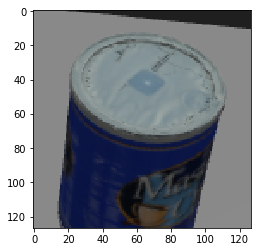

In [34]:
for j in range(10):
    obj_ind=-72 - j
    obj_name = ''.join(objs[obj_ind].split('_')[1:])
    obj_name
    try: 
        os.mkdir(path+obj_name) 
    except OSError as error: 
        print(error)  
    delete_object('spawned')
    move_base(1.25,1.15,np.pi)
    gaze_point(1.25,1.61,.6)
    
    x_gaz,y_gaz= world_2_gazebo(1.25,1.71)
    eu_i,eu_j,eu_k = 3.1416  ,0,0
    spawn_object('spawned',objs[obj_ind], x_gaz,  y_gaz,  0.45,eu_i,eu_j,eu_k )
    rospy.sleep(.1)
    num_imgs=200
    for i in range(num_imgs):
        contador=len(os.listdir(path+'/'+obj_name))

        x_gaz,y_gaz= world_2_gazebo(1.25,1.71)
        eu_i,eu_j,eu_k = 3.1416 - i*(3.1416/num_imgs) ,0,0
        spawn_object('spawned',objs[obj_ind], x_gaz,  y_gaz,  0.45,eu_i,eu_j,eu_k )
        rospy.sleep(.1)
        #res = service_client(req)
        cents,xyz, images=seg_pca(higher=25000)#res_to_cents(res)

        shapes_ratio=[]
        for image in images:
            print(np.abs(image.shape[0]-image.shape[1]))
            shapes_ratio.append(np.abs(image.shape[0]-image.shape[1]))

        if len (images)!=0:
            plt.imshow(images[np.argmin(shapes_ratio)])
            contador=len(os.listdir(path+'/'+obj_name))
            if np.min(shapes_ratio)< 10:
                cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[np.argmin(shapes_ratio)], cv2.COLOR_BGR2RGB))

        delete_object('spawned')
    
    

('cX,cY', 183, 459)
[-0.1634644   0.37900573  1.0059558 ]


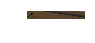

In [134]:
cents,xyz, images=seg_pca(higher=25000,plt_images=True)


reject


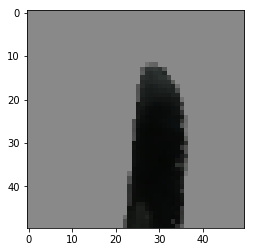

In [98]:
for image in images:
    if (image.shape[0]!=image.shape[1]):
        print ('reject')
    else:
        plt.imshow(image)

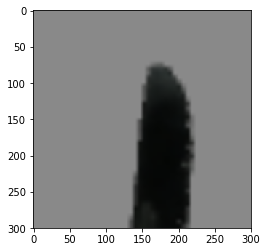

In [99]:
#img=tensorflow.image.resize(images,(300,300))
for image in images:
    img=tensorflow.image.resize(image,(300,300),preserve_aspect_ratio=True)
    
plt.imshow(img.numpy().astype('uint8'))
    

In [35]:
if len(images)==1:
    imgs= tensorflow.concat((img,img),axis=0)

In [36]:
imgs.shape

TensorShape([2, 300, 300, 3])

In [37]:
Y_pred = np.argmax(model.predict(imgs),axis=1)

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv2d/Conv2D (defined at <ipython-input-37-3604b6256509>:1) ]] [Op:__inference_distributed_function_789]

Function call stack:
distributed_function


In [ ]:
for image in images:
    if (image.shape[0]!=image.shape[1]):
        print ('reject')
    else:
        plt.imshow(image)

[INFO] [1641498316.008815, 343.556000]: Spawn: ycb_032_knife
[INFO] [1641498316.013585, 343.557000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1641498316.015469, 343.557000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1641498316.028057, 343.558000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1641498316.070059, 343.576000]: Spawn status: SpawnModel: Failure - entity already exists.
('Plane', 0, 'has', 0, 'objects')
[]
[INFO] [1641498317.986137, 344.198000]: Spawn: ycb_032_knife
[INFO] [1641498317.988940, 344.198000]: Spawn: [0.         0.         0.99987669 0.01570368]
[INFO] [1641498317.991093, 344.199000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1641498317.995946, 344.201000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1641498318.272378, 344.268000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
[array([0.06763976, 0.19731815, 0.87792359])]
60
[INFO] [1641498320.989957, 344.9640

KeyboardInterrupt: 

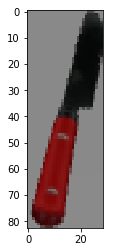

In [35]:

num_imgs=100
for i in range(num_imgs):
    contador=len(os.listdir(path+'/'+obj_name))

    x_gaz,y_gaz= world_2_gazebo(1.25,1.71)
    eu_i,eu_j,eu_k = 3.1416 - i*(3.1416/num_imgs) ,0,0
    spawn_object('spawned',objs[obj_ind], x_gaz,  y_gaz,  0.45,eu_i,eu_j,eu_k )
    rospy.sleep(.1)
    res = service_client(req)
    cents,xyz, images=res_to_cents(res)
    shapes_ratio=[]
    
    for image in images:
        print(np.abs(image.shape[0]-image.shape[1]))
        shapes_ratio.append(np.abs(image.shape[0]-image.shape[1]))
    if len (images)!=0:
        plt.imshow(images[np.argmin(shapes_ratio)])
        contador=len(os.listdir(path+'/'+obj_name))
        #cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[np.argmin(shapes_ratio)], cv2.COLOR_BGR2RGB))
    
    delete_object('spawned')

[INFO] [1641426029.447664, 1026.192000]: Spawn: ycb_032_knife
[INFO] [1641426029.452243, 1026.193000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1641426029.456881, 1026.193000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1641426029.471313, 1026.196000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1641426029.506803, 1026.206000]: Spawn status: SpawnModel: Failure - entity already exists.
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09041341, 0.17471232, 0.90635907])]
30
[INFO] [1641426032.280159, 1026.796000]: Spawn: ycb_032_knife
[INFO] [1641426032.282851, 1026.797000]: Spawn: [0.         0.         0.99996919 0.00785025]
[INFO] [1641426032.284691, 1026.798000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1641426032.295319, 1026.800000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1641426032.363394, 1026.807000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'obje

[INFO] [1641426094.443734, 1041.040000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07055037, 0.07644824, 0.84253714])]
29
[INFO] [1641426098.678809, 1042.045000]: Spawn: ycb_032_knife
[INFO] [1641426098.687924, 1042.047000]: Spawn: [0.         0.         0.99211512 0.12532988]
[INFO] [1641426098.691244, 1042.048000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1641426098.709557, 1042.051000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1641426098.972055, 1042.104000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07074776, 0.07628921, 0.84284899])]
28
[INFO] [1641426102.831366, 1043.052000]: Spawn: ycb_032_knife
[INFO] [1641426102.835544, 1043.052000]: Spawn: [0.         0.         0.99110019 0.13311801]
[INFO] [1641426102.837900, 1043.053000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [16414

[INFO] [1641426163.613217, 1057.278000]: Spawn: ycb_032_knife
[INFO] [1641426163.616549, 1057.278000]: Spawn: [0.         0.         0.97050722 0.24107205]
[INFO] [1641426163.618693, 1057.278000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1641426163.637416, 1057.281000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1641426163.850304, 1057.324000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07475896, 0.07374817, 0.84793933])]
7
[INFO] [1641426168.121958, 1058.369000]: Spawn: ycb_032_knife
[INFO] [1641426168.125645, 1058.370000]: Spawn: [0.         0.         0.96858393 0.2486869 ]
[INFO] [1641426168.128705, 1058.371000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1641426168.133232, 1058.372000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1641426168.345504, 1058.424000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'ha

[INFO] [1641426229.250622, 1072.581000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08040277, 0.07166825, 0.85227555])]
43
[INFO] [1641426233.503462, 1073.566000]: Spawn: ycb_032_knife
[INFO] [1641426233.506743, 1073.567000]: Spawn: [0.         0.         0.93264004 0.36080821]
[INFO] [1641426233.508980, 1073.567000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1641426233.513657, 1073.568000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1641426233.768824, 1073.616000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08105309, 0.07145203, 0.85270065])]
43
[INFO] [1641426238.306144, 1074.668000]: Spawn: ycb_032_knife
[INFO] [1641426238.309250, 1074.669000]: Spawn: [0.         0.         0.92977751 0.36812196]
[INFO] [1641426238.310961, 1074.669000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [16414

[INFO] [1641426299.195481, 1088.792000]: Spawn: ycb_032_knife
[INFO] [1641426299.198617, 1088.792000]: Spawn: [0.         0.         0.88376682 0.46792757]
[INFO] [1641426299.200720, 1088.792000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1641426299.213303, 1088.794000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1641426299.391781, 1088.828000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08895385, 0.07007889, 0.85596601])]
77
[INFO] [1641426303.653706, 1089.808000]: Spawn: ycb_032_knife
[INFO] [1641426303.657308, 1089.808000]: Spawn: [0.         0.         0.88006449 0.47485418]
[INFO] [1641426303.662138, 1089.808000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1641426303.702836, 1089.818000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1641426303.907036, 1089.854000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'h

[INFO] [1641426365.519865, 1104.139000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09748186, 0.06980049, 0.85704212])]
107
[INFO] [1641426369.622377, 1105.090000]: Spawn: ycb_032_knife
[INFO] [1641426369.625274, 1105.091000]: Spawn: [0.         0.         0.81815101 0.57500342]
[INFO] [1641426369.628606, 1105.091000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1641426369.634061, 1105.093000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1641426369.851740, 1105.136000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09834685, 0.06979518, 0.85712225])]
108
[INFO] [1641426374.124300, 1106.116000]: Spawn: ycb_032_knife
[INFO] [1641426374.127675, 1106.116000]: Spawn: [0.         0.         0.81360974 0.58141138]
[INFO] [1641426374.137343, 1106.116000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [164

[INFO] [1641426436.118344, 1120.364000]: Spawn: ycb_032_knife
[INFO] [1641426436.124088, 1120.367000]: Spawn: [0.         0.         0.74489537 0.6671813 ]
[INFO] [1641426436.126072, 1120.367000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1641426436.136873, 1120.370000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1641426436.214379, 1120.378000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10759604, 0.07093538, 0.85567765])]
123
[INFO] [1641426440.932275, 1121.443000]: Spawn: ycb_032_knife
[INFO] [1641426440.934939, 1121.443000]: Spawn: [0.         0.         0.73963241 0.67301107]
[INFO] [1641426440.936839, 1121.443000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1641426440.947228, 1121.446000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1641426441.128336, 1121.475000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, '

[INFO] [1641426504.761397, 1135.666000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11610754, 0.07350324, 0.85174034])]
109
[INFO] [1641426509.271453, 1136.636000]: Spawn: ycb_032_knife
[INFO] [1641426509.273960, 1136.636000]: Spawn: [0.         0.         0.65540143 0.75528072]
[INFO] [1641426509.278549, 1136.637000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1641426509.296806, 1136.640000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1641426509.531208, 1136.682000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11620638, 0.07358765, 0.85150633])]
107
[INFO] [1641426513.777832, 1137.637000]: Spawn: ycb_032_knife
[INFO] [1641426513.782357, 1137.638000]: Spawn: [0.         0.         0.64944931 0.76040489]
[INFO] [1641426513.786128, 1137.638000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [164

[INFO] [1641426576.904017, 1152.022000]: Spawn: ycb_032_knife
[INFO] [1641426576.909585, 1152.023000]: Spawn: [0.         0.         0.56208453 0.82707979]
[INFO] [1641426576.913772, 1152.023000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1641426576.938794, 1152.029000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1641426577.138353, 1152.062000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12366421, 0.07759771, 0.84505857])]
86
[INFO] [1641426581.860556, 1153.191000]: Spawn: ycb_032_knife
[INFO] [1641426581.867528, 1153.196000]: Spawn: [0.         0.         0.55557138 0.83146885]
[INFO] [1641426581.875564, 1153.199000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1641426581.904716, 1153.203000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1641426582.041015, 1153.231000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'h

[INFO] [1641426643.015496, 1167.338000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12923164, 0.08291848, 0.83799417])]
59
[INFO] [1641426647.032884, 1168.305000]: Spawn: ycb_032_knife
[INFO] [1641426647.035496, 1168.305000]: Spawn: [0.         0.         0.45399148 0.89100602]
[INFO] [1641426647.038318, 1168.305000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1641426647.053493, 1168.307000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1641426647.306635, 1168.356000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12898606, 0.08303697, 0.83755837])]
57
[INFO] [1641426651.405036, 1169.311000]: Spawn: ycb_032_knife
[INFO] [1641426651.412692, 1169.315000]: Spawn: [0.         0.         0.44697959 0.89454416]
[INFO] [1641426651.414558, 1169.315000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [16414

[INFO] [1641426714.519936, 1183.549000]: Spawn: ycb_032_knife
[INFO] [1641426714.524285, 1183.549000]: Spawn: [0.         0.         0.34611783 0.93819105]
[INFO] [1641426714.540197, 1183.551000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1641426714.554668, 1183.561000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1641426714.743897, 1183.601000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.13038934, 0.08849265, 0.82850907])]
24
[INFO] [1641426719.392805, 1184.598000]: Spawn: ycb_032_knife
[INFO] [1641426719.395774, 1184.598000]: Spawn: [0.         0.         0.33873868 0.9408805 ]
[INFO] [1641426719.397940, 1184.600000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1641426719.403587, 1184.601000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1641426719.687277, 1184.648000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'h

[INFO] [1641426782.591581, 1198.945000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12853639, 0.09374041, 0.81963706])]
12
[INFO] [1641426786.888366, 1199.934000]: Spawn: ycb_032_knife
[INFO] [1641426786.891608, 1199.935000]: Spawn: [0.         0.         0.22580179 0.97417327]
[INFO] [1641426786.895373, 1199.935000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1641426786.912395, 1199.941000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1641426787.113571, 1199.978000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12815312, 0.09390572, 0.81864386])]
16
[INFO] [1641426791.398820, 1200.958000]: Spawn: ycb_032_knife
[INFO] [1641426791.402123, 1200.958000]: Spawn: [0.         0.         0.21814374 0.97591665]
[INFO] [1641426791.404696, 1200.959000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [16414

KeyboardInterrupt: 

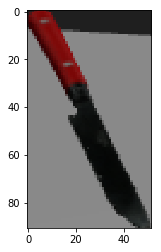

In [47]:

num_imgs=200
for i in range(num_imgs):
    contador=len(os.listdir(path+'/'+obj_name))

    x_gaz,y_gaz= world_2_gazebo(1.25,1.71)
    eu_i,eu_j,eu_k = 3.1416 - i*(3.1416/num_imgs) ,0,0
    spawn_object('spawned',objs[obj_ind], x_gaz,  y_gaz,  0.53,eu_i,eu_j,eu_k )
    rospy.sleep(.1)
    res = service_client(req)
    cents,xyz, images=res_to_cents(res)
    shapes_ratio=[]
   
    
    for image in images:
        print(np.abs(image.shape[0]-image.shape[1]))
        shapes_ratio.append(np.abs(image.shape[0]-image.shape[1]))
    if len(images)!=0:
        plt.imshow(images[np.argmin(shapes_ratio)])
        contador=len(os.listdir(path+'/'+obj_name))
        cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[np.argmin(shapes_ratio)], cv2.COLOR_BGR2RGB))
    
    delete_object('spawned')

('Plane', 0, 'has', 1, 'objects')
[array([0.07157893, 0.20136743, 0.86754994])]
('images[]', 0)


True

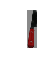

('i am at', [1.318575355232499, 0.9826928476596752, 1.0174952022954153], 179.4236909816111)
('gaze goal', 1.25, 1.71, 0.6)
('relative to robot', (0.06857535523249902, -0.7273071523403247, -84.61369656486625))
[INFO] [1639488917.524395, 11938.304000]: Spawn: ycb_050_medium_clamp
[INFO] [1639488917.530843, 11938.304000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1639488917.535936, 11938.304000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639488917.550398, 11938.305000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639488917.722470, 11938.308000]: Spawn status: SpawnModel: Successfully spawned entity
[INFO] [1639488917.723744, 11938.308000]: Spawn: ycb_050_medium_clamp
[INFO] [1639488917.725258, 11938.308000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1639488917.726841, 11938.308000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639488917.729362, 11938.308000]: Calling service /gazebo/spawn_sdf_mod

[INFO] [1639489089.807754, 11949.809000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 2, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.06964279, 0.160888  , 0.85390768]), array([0.18209645, 0.23106773, 0.8586441 ])]
14
60
[INFO] [1639489104.421798, 11950.807000]: Spawn: ycb_050_medium_clamp
[INFO] [1639489104.425359, 11950.807000]: Spawn: [0.         0.         0.97591745 0.21814016]
[INFO] [1639489104.427136, 11950.807000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639489104.434201, 11950.807000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639489104.776477, 11950.826000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 3, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07068794, 0.1627423 , 0.85985783]), array([0.18301636, 0.22342945, 0.87183917]), array([0.18235043, 0.23484171, 0.8521607 ])]
30
74
67
[INFO] [1639489118.948274, 11951.796000]: Spawn: ycb_050_medium_clamp
[INFO] [1639489118.951893, 

[INFO] [1639489301.459455, 11963.901000]: Spawn: ycb_050_medium_clamp
[INFO] [1639489301.461749, 11963.901000]: Spawn: [0.         0.         0.91140438 0.41151191]
[INFO] [1639489301.464460, 11963.902000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639489301.474439, 11963.902000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639489301.611187, 11963.903000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07265869, 0.14940001, 0.87428821])]
10
[INFO] [1639489316.985377, 11964.950000]: Spawn: ycb_050_medium_clamp
[INFO] [1639489316.989583, 11964.951000]: Spawn: [0.         0.         0.90482818 0.4257769 ]
[INFO] [1639489316.991572, 11964.951000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639489317.002252, 11964.952000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639489317.153357, 11964.954000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'o

[INFO] [1639489529.901986, 11979.127000]: Spawn: ycb_050_medium_clamp
[INFO] [1639489529.904430, 11979.127000]: Spawn: [0.         0.         0.79015632 0.61290537]
[INFO] [1639489529.906003, 11979.127000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639489529.909486, 11979.127000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639489530.060066, 11979.130000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07789728, 0.14360202, 0.87944277])]
21
[INFO] [1639489544.908067, 11980.115000]: Spawn: ycb_050_medium_clamp
[INFO] [1639489544.911245, 11980.115000]: Spawn: [0.         0.         0.78043172 0.62524102]
[INFO] [1639489544.913030, 11980.115000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639489544.924229, 11980.116000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639489545.066874, 11980.116000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'o

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.085873  , 0.14155118, 0.882685  ])]
25
[INFO] [1639489770.221151, 11995.259000]: Spawn: ycb_050_medium_clamp
[INFO] [1639489770.223519, 11995.259000]: Spawn: [0.         0.         0.61290827 0.79015407]
[INFO] [1639489770.224947, 11995.259000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639489770.230190, 11995.260000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639489770.371692, 11995.261000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08652896, 0.14153699, 0.88248421])]
24
[INFO] [1639489785.415426, 11996.277000]: Spawn: ycb_050_medium_clamp
[INFO] [1639489785.418630, 11996.277000]: Spawn: [0.         0.         0.60042143 0.79968375]
[INFO] [1639489785.421415, 11996.278000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639489785.430899, 11996.278000]: Calling service /gazebo/spawn_sdf_model
[INF

[INFO] [1639489998.323190, 12010.422000]: Spawn: ycb_050_medium_clamp
[INFO] [1639489998.326341, 12010.422000]: Spawn: [0.         0.         0.41151526 0.91140287]
[INFO] [1639489998.328036, 12010.422000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639489998.331161, 12010.422000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639489998.659089, 12010.438000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09410725, 0.14121707, 0.8822009 ])]
18
[INFO] [1639490013.105922, 12011.426000]: Spawn: ycb_050_medium_clamp
[INFO] [1639490013.109163, 12011.426000]: Spawn: [0.         0.         0.39714877 0.91775425]
[INFO] [1639490013.112033, 12011.427000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639490013.115382, 12011.427000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639490013.298229, 12011.430000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'o

('Plane', 0, 'has', 0, 'objects')
('Plane', 1, 'has', 0, 'objects')
[]
[INFO] [1639490229.255169, 12026.545000]: Spawn: ycb_050_medium_clamp
[INFO] [1639490229.257564, 12026.545000]: Spawn: [0.         0.         0.1719295  0.98510926]
[INFO] [1639490229.260297, 12026.546000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639490229.263856, 12026.546000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639490229.598763, 12026.561000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10288133, 0.14183693, 0.88006579])]
5
[INFO] [1639490244.447061, 12027.526000]: Spawn: ycb_050_medium_clamp
[INFO] [1639490244.449421, 12027.526000]: Spawn: [0.         0.         0.15643483 0.98768828]
[INFO] [1639490244.452189, 12027.526000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639490244.457078, 12027.527000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639490244.604306, 12027.528000]: Spawn sta

[INFO] [1639490460.549636, 12041.641000]: Spawn: ycb_050_medium_clamp
[INFO] [1639490460.552401, 12041.641000]: Spawn: [0.         0.         0.99802695 0.062787  ]
[INFO] [1639490460.555331, 12041.641000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639490460.563636, 12041.641000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639490460.734836, 12041.646000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07706514, 0.08862234, 0.81575506])]
12
[INFO] [1639490476.207262, 12042.674000]: Spawn: ycb_050_medium_clamp
[INFO] [1639490476.209730, 12042.674000]: Spawn: [0.         0.         0.99691761 0.07845562]
[INFO] [1639490476.211483, 12042.674000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639490476.215250, 12042.674000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639490476.388925, 12042.679000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'o

[INFO] [1639490691.594555, 12056.908000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.06999675, 0.08274368, 0.82546616])]
9
[INFO] [1639490706.483026, 12057.883000]: Spawn: ycb_050_medium_clamp
[INFO] [1639490706.485949, 12057.883000]: Spawn: [0.         0.         0.95105742 0.3090142 ]
[INFO] [1639490706.487534, 12057.883000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639490706.494595, 12057.884000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639490706.811808, 12057.902000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.06963703, 0.08226202, 0.82615253])]
10
[INFO] [1639490721.866247, 12058.894000]: Spawn: ycb_050_medium_clamp
[INFO] [1639490721.868826, 12058.895000]: Spawn: [0.         0.         0.9460863  0.32391467]
[INFO] [1639490721.870357, 12058.895000]: Waiting for service /gazebo/spawn_s

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07255388, 0.07656468, 0.83536745])]
23
[INFO] [1639490934.467834, 12072.976000]: Spawn: ycb_050_medium_clamp
[INFO] [1639490934.471036, 12072.976000]: Spawn: [0.         0.         0.85264141 0.52249653]
[INFO] [1639490934.472946, 12072.977000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639490934.475991, 12072.977000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639490934.798134, 12072.995000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07286675, 0.07630166, 0.835709  ])]
24
[INFO] [1639490949.855898, 12073.969000]: Spawn: ycb_050_medium_clamp
[INFO] [1639490949.858232, 12073.969000]: Spawn: [0.         0.         0.84432919 0.53582481]
[INFO] [1639490949.859731, 12073.969000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639490949.862807, 12073.969000]: Calling service /gazebo/spawn_sdf_model
[INF

[INFO] [1639491166.787942, 12088.066000]: Spawn: ycb_050_medium_clamp
[INFO] [1639491166.790144, 12088.066000]: Spawn: [0.         0.         0.70710808 0.70710548]
[INFO] [1639491166.792039, 12088.066000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639491166.798062, 12088.066000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639491167.127699, 12088.080000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08048687, 0.07343985, 0.84088211])]
23
[INFO] [1639491183.169505, 12089.083000]: Spawn: ycb_050_medium_clamp
[INFO] [1639491183.171968, 12089.083000]: Spawn: [0.         0.         0.69591409 0.71812505]
[INFO] [1639491183.173354, 12089.083000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639491183.186164, 12089.084000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639491183.358874, 12089.087000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'o

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08843488, 0.07256886, 0.84204305])]
27
[INFO] [1639491413.195353, 12104.265000]: Spawn: ycb_050_medium_clamp
[INFO] [1639491413.198804, 12104.265000]: Spawn: [0.         0.         0.50904249 0.86074139]
[INFO] [1639491413.200563, 12104.265000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639491413.209288, 12104.266000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639491413.469822, 12104.279000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08867665, 0.07249563, 0.84210603])]
28
[INFO] [1639491428.102269, 12105.223000]: Spawn: ycb_050_medium_clamp
[INFO] [1639491428.104965, 12105.223000]: Spawn: [0.         0.         0.49545972 0.86863091]
[INFO] [1639491428.107118, 12105.223000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639491428.114135, 12105.224000]: Calling service /gazebo/spawn_sdf_model
[INF

[INFO] [1639491643.790625, 12119.343000]: Spawn: ycb_050_medium_clamp
[INFO] [1639491643.793283, 12119.343000]: Spawn: [0.         0.         0.29404099 0.95579281]
[INFO] [1639491643.794908, 12119.344000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639491643.802096, 12119.344000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639491643.957362, 12119.347000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09612217, 0.07289223, 0.84023284])]
16
[INFO] [1639491659.983187, 12120.369000]: Spawn: ycb_050_medium_clamp
[INFO] [1639491659.986367, 12120.369000]: Spawn: [0.         0.         0.27899174 0.9602935 ]
[INFO] [1639491659.987924, 12120.369000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639491659.992713, 12120.369000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639491660.147314, 12120.371000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'o

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10547718, 0.07395592, 0.83808077])]
8
[INFO] [1639491888.866615, 12135.603000]: Spawn: ycb_050_medium_clamp
[INFO] [1639491888.869287, 12135.603000]: Spawn: [0.         0.         0.04710656 0.99888987]
[INFO] [1639491888.871761, 12135.603000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639491888.883209, 12135.604000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639491889.233484, 12135.625000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10606401, 0.07411843, 0.83762315])]
8
[INFO] [1639491903.941689, 12136.602000]: Spawn: ycb_050_medium_clamp
[INFO] [1639491903.944728, 12136.603000]: Spawn: [0.         0.         0.03141083 0.99950656]
[INFO] [1639491903.946910, 12136.603000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639491903.970426, 12136.603000]: Calling service /gazebo/spawn_sdf_model
[INFO]

('Plane', 0, 'has', 0, 'objects')
('Plane', 1, 'has', 0, 'objects')
[]
[INFO] [1639492139.770972, 12153.852000]: Spawn: ycb_048_hammer
[INFO] [1639492139.773508, 12153.853000]: Spawn: [0.         0.         0.98510989 0.17192588]
[INFO] [1639492139.775182, 12153.853000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639492139.778178, 12153.853000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639492140.116781, 12153.870000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10359056, 0.130915  , 0.88874689])]
144
[INFO] [1639492154.586395, 12154.808000]: Spawn: ycb_048_hammer
[INFO] [1639492154.589111, 12154.808000]: Spawn: [0.         0.         0.98228786 0.18737814]
[INFO] [1639492154.590666, 12154.808000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639492154.593795, 12154.808000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639492154.735876, 12154.809000]: Spawn status: Spawn

[INFO] [1639492377.399879, 12169.027000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12467504, 0.13834492, 0.87636212])]
87
[INFO] [1639492392.961858, 12170.039000]: Spawn: ycb_048_hammer
[INFO] [1639492392.964390, 12170.039000]: Spawn: [0.         0.         0.91140438 0.41151191]
[INFO] [1639492392.967415, 12170.039000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639492392.974039, 12170.040000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639492393.154048, 12170.043000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12575081, 0.1392058 , 0.87499897])]
82
[INFO] [1639492408.570650, 12171.055000]: Spawn: ycb_048_hammer
[INFO] [1639492408.573582, 12171.055000]: Spawn: [0.         0.         0.90482818 0.4257769 ]
[INFO] [1639492408.575219, 12171.055000]: Waiting for service /gazebo/spawn_sdf_model
[I

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.13386883, 0.14477582, 0.86402942])]
23
[INFO] [1639492627.635675, 12185.261000]: Spawn: ycb_048_hammer
[INFO] [1639492627.638363, 12185.261000]: Spawn: [0.         0.         0.79015632 0.61290537]
[INFO] [1639492627.640539, 12185.261000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639492627.658416, 12185.263000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639492627.983990, 12185.278000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.13453373, 0.1460853 , 0.86225207])]
17
[INFO] [1639492643.925060, 12186.273000]: Spawn: ycb_048_hammer
[INFO] [1639492643.929303, 12186.274000]: Spawn: [0.         0.         0.78043172 0.62524102]
[INFO] [1639492643.930870, 12186.274000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639492643.937610, 12186.274000]: Calling service /gazebo/spawn_sdf_model
[INFO] [16394926

[INFO] [1639492861.929811, 12200.391000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12791273, 0.16034397, 0.8404469 ])]
40
[INFO] [1639492877.344302, 12201.374000]: Spawn: ycb_048_hammer
[INFO] [1639492877.346997, 12201.374000]: Spawn: [0.         0.         0.61290827 0.79015407]
[INFO] [1639492877.348524, 12201.374000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639492877.360805, 12201.375000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639492877.525766, 12201.379000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12616721, 0.16604907, 0.83093994])]
42
[INFO] [1639492893.231175, 12202.378000]: Spawn: ycb_048_hammer
[INFO] [1639492893.233821, 12202.378000]: Spawn: [0.         0.         0.60042143 0.79968375]
[INFO] [1639492893.235290, 12202.378000]: Waiting for service /gazebo/spawn_sdf_model
[I

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11484262, 0.16596403, 0.82758474])]
32
[INFO] [1639493114.337215, 12216.501000]: Spawn: ycb_048_hammer
[INFO] [1639493114.340295, 12216.501000]: Spawn: [0.         0.         0.41151526 0.91140287]
[INFO] [1639493114.342695, 12216.501000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639493114.348830, 12216.502000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639493114.505775, 12216.503000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11221402, 0.16715371, 0.82661861])]
18
[INFO] [1639493131.003062, 12217.513000]: Spawn: ycb_048_hammer
[INFO] [1639493131.005868, 12217.513000]: Spawn: [0.         0.         0.39714877 0.91775425]
[INFO] [1639493131.008899, 12217.514000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639493131.012495, 12217.514000]: Calling service /gazebo/spawn_sdf_model
[INFO] [16394931

[INFO] [1639493355.364239, 12231.655000]: Spawn: ycb_048_hammer
[INFO] [1639493355.369848, 12231.656000]: Spawn: [0.         0.         0.18738175 0.98228717]
[INFO] [1639493355.373311, 12231.656000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639493355.380518, 12231.656000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639493355.667854, 12231.670000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.1010792 , 0.16549321, 0.82702314])]
75
[INFO] [1639493371.962339, 12232.683000]: Spawn: ycb_048_hammer
[INFO] [1639493371.964897, 12232.684000]: Spawn: [0.         0.         0.1719295  0.98510926]
[INFO] [1639493371.966443, 12232.684000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639493371.971524, 12232.684000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639493372.122863, 12232.686000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 0, 'objects')
('P

[INFO] [1639493593.125254, 12246.861000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08926691, 0.06210304, 0.84903406])]
163
[INFO] [1639493608.443435, 12247.803000]: Spawn: ycb_048_hammer
[INFO] [1639493608.446782, 12247.803000]: Spawn: [0.         0.         0.99802695 0.062787  ]
[INFO] [1639493608.451945, 12247.804000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639493608.466415, 12247.804000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639493608.755621, 12247.817000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09081871, 0.06204566, 0.84914177])]
164
[INFO] [1639493624.818596, 12248.817000]: Spawn: ycb_048_hammer
[INFO] [1639493624.821830, 12248.817000]: Spawn: [0.         0.         0.99691761 0.07845562]
[INFO] [1639493624.823710, 12248.818000]: Waiting for service /gazebo/spawn_sdf_model


('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11130011, 0.06466196, 0.84420841])]
138
[INFO] [1639493855.291471, 12263.033000]: Spawn: ycb_048_hammer
[INFO] [1639493855.298534, 12263.033000]: Spawn: [0.         0.         0.95579389 0.29403748]
[INFO] [1639493855.303086, 12263.034000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639493855.325880, 12263.036000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639493855.677584, 12263.055000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11222842, 0.06501371, 0.84354878])]
135
[INFO] [1639493871.591619, 12264.084000]: Spawn: ycb_048_hammer
[INFO] [1639493871.594021, 12264.084000]: Spawn: [0.         0.         0.95105742 0.3090142 ]
[INFO] [1639493871.595450, 12264.084000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639493871.598606, 12264.084000]: Calling service /gazebo/spawn_sdf_model
[INFO] [163949

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.1288821 , 0.07582207, 0.8232783 ])]
61
[INFO] [1639494106.017214, 12279.175000]: Spawn: ycb_048_hammer
[INFO] [1639494106.023506, 12279.175000]: Spawn: [0.         0.         0.85264141 0.52249653]
[INFO] [1639494106.029478, 12279.176000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639494106.039942, 12279.177000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639494106.323330, 12279.192000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.1293522 , 0.07674138, 0.82155795])]
55
[INFO] [1639494121.519907, 12280.198000]: Spawn: ycb_048_hammer
[INFO] [1639494121.522499, 12280.198000]: Spawn: [0.         0.         0.84432919 0.53582481]
[INFO] [1639494121.525179, 12280.198000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639494121.528616, 12280.198000]: Calling service /gazebo/spawn_sdf_model
[INFO] [16394941

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12980739, 0.09216371, 0.79279218])]
18
[INFO] [1639494351.492248, 12295.358000]: Spawn: ycb_048_hammer
[INFO] [1639494351.494565, 12295.358000]: Spawn: [0.         0.         0.69591409 0.71812505]
[INFO] [1639494351.497163, 12295.359000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639494351.502102, 12295.359000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639494351.797840, 12295.370000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12983447, 0.09395187, 0.79191201])]
22
[INFO] [1639494366.303701, 12296.313000]: Spawn: ycb_048_hammer
[INFO] [1639494366.306230, 12296.313000]: Spawn: [0.         0.         0.68454839 0.72896742]
[INFO] [1639494366.308057, 12296.313000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639494366.315593, 12296.314000]: Calling service /gazebo/spawn_sdf_model
[INFO] [16394943

[INFO] [1639494589.371700, 12310.394000]: Spawn: ycb_048_hammer
[INFO] [1639494589.374398, 12310.394000]: Spawn: [0.         0.         0.50904249 0.86074139]
[INFO] [1639494589.376093, 12310.394000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639494589.379384, 12310.394000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639494589.561552, 12310.397000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11299956, 0.10517658, 0.77035496])]
29
[INFO] [1639494605.249792, 12311.415000]: Spawn: ycb_048_hammer
[INFO] [1639494605.252643, 12311.415000]: Spawn: [0.         0.         0.49545972 0.86863091]
[INFO] [1639494605.254303, 12311.416000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639494605.257496, 12311.416000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639494605.442533, 12311.420000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('P

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09374856, 0.10434549, 0.77326609])]
44
[INFO] [1639494847.028662, 12326.574000]: Spawn: ycb_048_hammer
[INFO] [1639494847.032418, 12326.575000]: Spawn: [0.         0.         0.27899174 0.9602935 ]
[INFO] [1639494847.034276, 12326.575000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639494847.038095, 12326.575000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639494847.372017, 12326.591000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09270171, 0.10405369, 0.77383898])]
50
[INFO] [1639494863.781210, 12327.601000]: Spawn: ycb_048_hammer
[INFO] [1639494863.784045, 12327.601000]: Spawn: [0.         0.         0.26387365 0.96455725]
[INFO] [1639494863.785558, 12327.601000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639494863.790869, 12327.601000]: Calling service /gazebo/spawn_sdf_model
[INFO] [16394948

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08752234, 0.09826346, 0.78454088])]
132
[INFO] [1639495103.213331, 12342.763000]: Spawn: ycb_048_hammer
[INFO] [1639495103.216254, 12342.763000]: Spawn: [0.         0.         0.03141083 0.99950656]
[INFO] [1639495103.218278, 12342.763000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639495103.222279, 12342.764000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639495103.556357, 12342.783000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08758385, 0.09794284, 0.78505984])]
137
[INFO] [1639495119.643244, 12343.795000]: Spawn: ycb_048_hammer
[INFO] [1639495119.645984, 12343.795000]: Spawn: [0.         0.         0.01570735 0.99987663]
[INFO] [1639495119.647978, 12343.795000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639495119.654017, 12343.796000]: Calling service /gazebo/spawn_sdf_model
[INFO] [163949

[INFO] [1639495351.545917, 12359.968000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07589934, 0.15000453, 0.85529435])]
90
[INFO] [1639495367.168807, 12360.949000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639495367.171469, 12360.950000]: Spawn: [0.         0.         0.98228786 0.18737814]
[INFO] [1639495367.173127, 12360.950000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639495367.177800, 12360.950000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639495367.335023, 12360.952000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07580654, 0.14977529, 0.85626347])]
96
[INFO] [1639495384.256109, 12361.981000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639495384.258603, 12361.981000]: Spawn: [0.         0.         0.97922346 0.20278417]
[INFO] [1639495384.263950, 12361.982000]: Waiting for service /gazeb

[INFO] [1639495590.343765, 12375.063000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07836815, 0.14598443, 0.86331424])]
112
[INFO] [1639495605.847686, 12376.061000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639495605.849956, 12376.061000]: Spawn: [0.         0.         0.91140438 0.41151191]
[INFO] [1639495605.851395, 12376.061000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639495605.872111, 12376.063000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639495606.022855, 12376.063000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 5, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08832468, 0.14840553, 0.86269784]), array([-0.27942729,  0.21036485,  0.89542734]), array([-0.09059009,  0.21404668,  0.88893337]), array([0.00514901, 0.21617574, 0.88513885]), array([-0.03917181,  0.23324422,  0.85553903])]
112
46
22
56
117
[INFO] [1639495623.031792, 12377.

[INFO] [1639495838.805638, 12390.308000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08418638, 0.14403309, 0.86801979])]
62
[INFO] [1639495853.936143, 12391.278000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639495853.938614, 12391.278000]: Spawn: [0.         0.         0.79015632 0.61290537]
[INFO] [1639495853.940099, 12391.278000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639495853.944556, 12391.278000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639495854.107565, 12391.280000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08471603, 0.14409678, 0.86786503])]
58
[INFO] [1639495870.595867, 12392.267000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639495870.598684, 12392.267000]: Spawn: [0.         0.         0.78043172 0.62524102]
[INFO] [1639495870.601713, 12392.268000]: Waiting for service /gazeb

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08899337, 0.14312684, 0.86816545])]
3
[INFO] [1639496101.365017, 12406.364000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639496101.367247, 12406.364000]: Spawn: [0.         0.         0.62524389 0.78042942]
[INFO] [1639496101.368824, 12406.364000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639496101.383962, 12406.365000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639496101.688891, 12406.380000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08993914, 0.14405022, 0.86942554])]
8
[INFO] [1639496118.088313, 12407.375000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639496118.090571, 12407.375000]: Spawn: [0.         0.         0.61290827 0.79015407]
[INFO] [1639496118.092100, 12407.375000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639496118.104721, 12407.376000]: Calling service /gazebo/spawn_sdf_mode

[INFO] [1639496342.000347, 12421.500000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639496342.002912, 12421.500000]: Spawn: [0.         0.         0.42578022 0.90482661]
[INFO] [1639496342.004460, 12421.500000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639496342.018473, 12421.501000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639496342.357774, 12421.517000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09413643, 0.15114964, 0.86756316])]
76
[INFO] [1639496358.089909, 12422.491000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639496358.092616, 12422.491000]: Spawn: [0.         0.         0.41151526 0.91140287]
[INFO] [1639496358.094323, 12422.491000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639496358.102275, 12422.492000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639496358.286941, 12422.496000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has

[INFO] [1639496588.989549, 12436.667000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639496588.991695, 12436.667000]: Spawn: [0.         0.         0.20278776 0.97922271]
[INFO] [1639496588.994141, 12436.667000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639496588.997831, 12436.668000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639496589.333798, 12436.682000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.0945559 , 0.14814439, 0.86782944])]
28
[INFO] [1639496606.185690, 12437.703000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639496606.188244, 12437.703000]: Spawn: [0.         0.         0.18738175 0.98228717]
[INFO] [1639496606.190158, 12437.703000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639496606.198670, 12437.704000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639496606.537818, 12437.721000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has

[INFO] [1639496835.227294, 12451.869000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639496835.229565, 12451.869000]: Spawn: [0.         0.         0.99950667 0.03140716]
[INFO] [1639496835.231514, 12451.869000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639496835.238946, 12451.869000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639496835.387769, 12451.870000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 0, 'objects')
('Plane', 1, 'has', 0, 'objects')
[]
[INFO] [1639496847.453224, 12452.872000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639496847.456149, 12452.872000]: Spawn: [0.         0.         0.99889004 0.04710289]
[INFO] [1639496847.459180, 12452.873000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639496847.488721, 12452.875000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639496847.669462, 12452.880000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objec

[INFO] [1639497082.701677, 12466.994000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639497082.704105, 12466.994000]: Spawn: [0.         0.         0.96455822 0.26387011]
[INFO] [1639497082.705561, 12466.994000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639497082.708206, 12466.994000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639497082.870010, 12466.996000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 0, 'objects')
('Plane', 1, 'has', 0, 'objects')
[]
[INFO] [1639497095.310161, 12468.009000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639497095.314182, 12468.009000]: Spawn: [0.         0.         0.96029453 0.27898821]
[INFO] [1639497095.316491, 12468.010000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639497095.320478, 12468.010000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639497095.585191, 12468.020000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objec

[INFO] [1639497325.431290, 12482.141000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639497325.433754, 12482.141000]: Spawn: [0.         0.         0.87630788 0.48175149]
[INFO] [1639497325.435380, 12482.141000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639497325.440681, 12482.141000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639497325.778522, 12482.158000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07823228, 0.07642208, 0.82530284])]
103
[INFO] [1639497341.207164, 12483.135000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639497341.219267, 12483.137000]: Spawn: [0.         0.         0.86863273 0.49545653]
[INFO] [1639497341.221376, 12483.138000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639497341.235487, 12483.139000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639497341.528435, 12483.153000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'ha

[INFO] [1639497581.531230, 12497.339000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639497581.535377, 12497.339000]: Spawn: [0.         0.         0.73963241 0.67301107]
[INFO] [1639497581.538652, 12497.340000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639497581.564062, 12497.341000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639497581.844917, 12497.352000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.0836153 , 0.07475063, 0.82775505])]
46
[INFO] [1639497599.104248, 12498.344000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639497599.106720, 12498.344000]: Spawn: [0.         0.         0.72896993 0.68454571]
[INFO] [1639497599.109276, 12498.345000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639497599.113097, 12498.345000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639497599.278540, 12498.347000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has

[INFO] [1639497838.600375, 12512.455000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639497838.603344, 12512.455000]: Spawn: [0.         0.         0.56208453 0.82707979]
[INFO] [1639497838.605644, 12512.456000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639497838.609210, 12512.456000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639497838.927400, 12512.473000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08830993, 0.0740509 , 0.82716619])]
23
[INFO] [1639497855.609871, 12513.474000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639497855.612533, 12513.474000]: Spawn: [0.         0.         0.54902395 0.83580662]
[INFO] [1639497855.614190, 12513.474000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639497855.623924, 12513.475000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639497855.976013, 12513.492000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has

[INFO] [1639498096.247737, 12527.617000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639498096.250455, 12527.617000]: Spawn: [0.         0.         0.35347563 0.93544373]
[INFO] [1639498096.252279, 12527.617000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639498096.256795, 12527.618000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639498096.572613, 12527.631000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09249683, 0.07638918, 0.82794311])]
72
[INFO] [1639498114.360847, 12528.676000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639498114.364243, 12528.676000]: Spawn: [0.         0.         0.33873868 0.9408805 ]
[INFO] [1639498114.368756, 12528.676000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639498114.388078, 12528.678000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639498114.643627, 12528.689000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has

[INFO] [1639498343.866050, 12542.852000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09689092, 0.07469737, 0.82592786])]
2
[INFO] [1639498359.932383, 12543.799000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639498359.934919, 12543.799000]: Spawn: [0.         0.         0.10973457 0.99396093]
[INFO] [1639498359.936481, 12543.799000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639498359.942170, 12543.800000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639498360.138463, 12543.802000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.0969658 , 0.07494718, 0.82573451])]
8
[INFO] [1639498377.664710, 12544.823000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639498377.667651, 12544.823000]: Spawn: [0.         0.         0.09410853 0.99556194]
[INFO] [1639498377.669638, 12544.823000]: Waiting for service /gazebo/

('Plane', 0, 'has', 0, 'objects')
('Plane', 1, 'has', 0, 'objects')
[]
[INFO] [1639498628.179534, 12561.993000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639498628.182613, 12561.993000]: Spawn: [0.         0.         0.99396133 0.10973092]
[INFO] [1639498628.184283, 12561.993000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639498628.191172, 12561.993000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639498628.354119, 12561.995000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11443741, 0.14807847, 0.85511784])]
39
[INFO] [1639498645.066588, 12563.046000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639498645.069139, 12563.046000]: Spawn: [0.         0.         0.99211512 0.12532988]
[INFO] [1639498645.070446, 12563.046000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639498645.073999, 12563.046000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639498645.249916, 12563.0

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11123112, 0.15368907, 0.85255148])]
45
[INFO] [1639498883.911345, 12577.238000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639498883.913958, 12577.238000]: Spawn: [0.         0.         0.94088174 0.33873522]
[INFO] [1639498883.915419, 12577.238000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639498883.919743, 12577.238000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639498884.235202, 12577.257000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11055807, 0.15324459, 0.85068552])]
41
[INFO] [1639498901.725074, 12578.255000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639498901.729500, 12578.256000]: Spawn: [0.         0.         0.93544503 0.3534722 ]
[INFO] [1639498901.731249, 12578.256000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639498901.734180, 12578.256000]: Calling service /gazebo/spaw

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10581397, 0.15401294, 0.84670128])]
24
[INFO] [1639499134.301922, 12592.438000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639499134.304334, 12592.438000]: Spawn: [0.         0.         0.83580863 0.54902088]
[INFO] [1639499134.305941, 12592.438000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639499134.325052, 12592.439000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639499134.670990, 12592.456000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10511056, 0.15449582, 0.84675202])]
28
[INFO] [1639499152.017791, 12593.443000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639499152.020523, 12593.443000]: Spawn: [0.         0.         0.82708185 0.56208149]
[INFO] [1639499152.022182, 12593.443000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639499152.026146, 12593.443000]: Calling service /gazebo/spaw

('Plane', 0, 'has', 0, 'objects')
('Plane', 1, 'has', 0, 'objects')
[]
[INFO] [1639499388.608796, 12607.696000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639499388.611815, 12607.697000]: Spawn: [0.         0.         0.68454839 0.72896742]
[INFO] [1639499388.613187, 12607.697000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639499388.626004, 12607.698000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639499388.795757, 12607.701000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10116614, 0.15539458, 0.84536591])]
97
[INFO] [1639499404.504483, 12608.639000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639499404.508115, 12608.640000]: Spawn: [0.         0.         0.67301379 0.73962993]
[INFO] [1639499404.509600, 12608.640000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639499404.513541, 12608.640000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639499404.667669, 12608.6

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09651882, 0.15647947, 0.8443615 ])]
113
[INFO] [1639499640.710372, 12622.747000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639499640.712956, 12622.747000]: Spawn: [0.         0.         0.49545972 0.86863091]
[INFO] [1639499640.714398, 12622.747000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639499640.718989, 12622.747000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639499640.898862, 12622.750000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09624433, 0.15662051, 0.84456822])]
109
[INFO] [1639499658.868034, 12623.771000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639499658.871303, 12623.771000]: Spawn: [0.         0.         0.4817547  0.87630611]
[INFO] [1639499658.873475, 12623.772000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639499658.876740, 12623.772000]: Calling service /gazebo/sp

[INFO] [1639499881.437482, 12636.913000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09037349, 0.15722356, 0.84386856])]
62
[INFO] [1639499897.958902, 12637.916000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639499897.961814, 12637.916000]: Spawn: [0.         0.         0.27899174 0.9602935 ]
[INFO] [1639499897.963616, 12637.916000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639499897.967141, 12637.917000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639499898.138771, 12637.919000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 0, 'objects')
('Plane', 1, 'has', 0, 'objects')
[]
[INFO] [1639499910.463643, 12638.898000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639499910.466430, 12638.898000]: Spawn: [0.         0.         0.26387365 0.96455725]
[INFO] [1639499910.468577, 12638.898000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639499910.4

[INFO] [1639500136.765024, 12652.060000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07538857, 0.14900602, 0.85544815])]
7
[INFO] [1639500153.779529, 12653.062000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639500153.782300, 12653.062000]: Spawn: [0.         0.         0.04710656 0.99888987]
[INFO] [1639500153.784627, 12653.063000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639500153.791004, 12653.063000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639500154.111610, 12653.078000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07521326, 0.14865757, 0.85574288])]
10
[INFO] [1639500171.026057, 12654.097000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639500171.029114, 12654.098000]: Spawn: [0.         0.         0.03141083 0.99950656]
[INFO] [1639500171.030995, 12654.098000]: Waiting for service

[INFO] [1639500403.851816, 12667.239000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11145803, 0.08087534, 0.80963921])]
49
[INFO] [1639500421.016230, 12668.242000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639500421.018878, 12668.242000]: Spawn: [0.         0.         0.98228786 0.18737814]
[INFO] [1639500421.020629, 12668.242000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639500421.027199, 12668.243000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639500421.193281, 12668.245000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11120085, 0.08101363, 0.80906243])]
51
[INFO] [1639500438.462933, 12669.262000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639500438.465946, 12669.262000]: Spawn: [0.         0.         0.97922346 0.20278417]
[INFO] [1639500438.468064, 12669.262000]: Waiting for servic

[INFO] [1639500661.091837, 12682.426000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10687791, 0.08405611, 0.80459728])]
18
[INFO] [1639500677.683306, 12683.386000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639500677.685899, 12683.386000]: Spawn: [0.         0.         0.91140438 0.41151191]
[INFO] [1639500677.689971, 12683.387000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639500677.702356, 12683.388000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639500678.063199, 12683.404000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10644099, 0.08439479, 0.80427   ])]
14
[INFO] [1639500696.297679, 12684.404000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639500696.300479, 12684.404000]: Spawn: [0.         0.         0.90482818 0.4257769 ]
[INFO] [1639500696.304409, 12684.405000]: Waiting for servic

[INFO] [1639500925.036037, 12697.554000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10256485, 0.08595881, 0.80470936])]
53
[INFO] [1639500942.384177, 12698.572000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639500942.386867, 12698.572000]: Spawn: [0.         0.         0.79015632 0.61290537]
[INFO] [1639500942.388457, 12698.572000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639500942.391915, 12698.572000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639500942.751491, 12698.586000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10229684, 0.08605936, 0.80472284])]
59
[INFO] [1639500959.546823, 12699.571000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639500959.549330, 12699.572000]: Spawn: [0.         0.         0.78043172 0.62524102]
[INFO] [1639500959.551052, 12699.572000]: Waiting for servic

[INFO] [1639501184.865619, 12712.709000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09825031, 0.08739577, 0.80466614])]
116
[INFO] [1639501203.029776, 12713.695000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639501203.033584, 12713.695000]: Spawn: [0.         0.         0.62524389 0.78042942]
[INFO] [1639501203.036148, 12713.696000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639501203.041120, 12713.696000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639501203.214298, 12713.698000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09797133, 0.08742929, 0.80458874])]
118
[INFO] [1639501221.463698, 12714.721000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639501221.467759, 12714.721000]: Spawn: [0.         0.         0.61290827 0.79015407]
[INFO] [1639501221.470114, 12714.722000]: Waiting for serv

[INFO] [1639501451.100686, 12727.866000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09266456, 0.08838688, 0.80376529])]
105
[INFO] [1639501468.844463, 12728.860000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639501468.847074, 12728.860000]: Spawn: [0.         0.         0.42578022 0.90482661]
[INFO] [1639501468.848805, 12728.860000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639501468.853042, 12728.861000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639501469.021918, 12728.864000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09269298, 0.08854923, 0.8035717 ])]
103
[INFO] [1639501486.059121, 12729.869000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639501486.063093, 12729.870000]: Spawn: [0.         0.         0.41151526 0.91140287]
[INFO] [1639501486.064733, 12729.870000]: Waiting for serv

[INFO] [1639501711.660804, 12743.009000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08516666, 0.08827898, 0.80342157])]
46
[INFO] [1639501729.236521, 12743.995000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639501729.239323, 12743.995000]: Spawn: [0.         0.         0.20278776 0.97922271]
[INFO] [1639501729.241002, 12743.995000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639501729.247869, 12743.996000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639501729.592233, 12744.009000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08493274, 0.08840567, 0.80320392])]
42
[INFO] [1639501748.400609, 12745.072000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639501748.403663, 12745.072000]: Spawn: [0.         0.         0.18738175 0.98228717]
[INFO] [1639501748.405627, 12745.072000]: Waiting for servic

('Plane', 0, 'has', 0, 'objects')
('Plane', 1, 'has', 0, 'objects')
[]
[INFO] [1639502024.693350, 12762.739000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639502024.697101, 12762.740000]: Spawn: [0.         0.         0.99987669 0.01570368]
[INFO] [1639502024.698828, 12762.740000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639502024.710152, 12762.740000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639502024.863199, 12762.741000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.06629206, 0.15807116, 0.87634413])]
74
[INFO] [1639502034.699327, 12763.269000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639502034.702276, 12763.269000]: Spawn: [0.         0.         0.99950667 0.03140716]
[INFO] [1639502034.704104, 12763.269000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639502034.710917, 12763.269000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639502034.880478, 12763.271000]

[INFO] [1639502278.877664, 12777.466000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639502278.881215, 12777.467000]: Spawn: [0.         0.         0.96858393 0.2486869 ]
[INFO] [1639502278.882864, 12777.467000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639502278.885803, 12777.467000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639502279.216026, 12777.483000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07467593, 0.15173835, 0.88630128])]
99
[INFO] [1639502297.245068, 12778.469000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639502297.247304, 12778.469000]: Spawn: [0.         0.         0.96455822 0.26387011]
[INFO] [1639502297.248625, 12778.469000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639502297.251634, 12778.469000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639502297.440073, 12778.471000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'h

[INFO] [1639502543.815911, 12792.583000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639502543.818896, 12792.583000]: Spawn: [0.         0.         0.88376682 0.46792757]
[INFO] [1639502543.820528, 12792.583000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639502543.826613, 12792.583000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639502544.175061, 12792.599000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.0877078 , 0.14970533, 0.89080811])]
63
[INFO] [1639502561.317425, 12793.586000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639502561.320158, 12793.586000]: Spawn: [0.         0.         0.87630788 0.48175149]
[INFO] [1639502561.322166, 12793.586000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639502561.330141, 12793.587000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639502561.661908, 12793.603000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'h

[INFO] [1639502814.310611, 12807.742000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639502814.313825, 12807.743000]: Spawn: [0.         0.         0.75011238 0.66131038]
[INFO] [1639502814.315681, 12807.743000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639502814.322678, 12807.743000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639502814.664063, 12807.757000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09904337, 0.15121156, 0.8901005 ])]
12
[INFO] [1639502832.491210, 12808.764000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639502832.494049, 12808.764000]: Spawn: [0.         0.         0.73963241 0.67301107]
[INFO] [1639502832.496087, 12808.764000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639502832.503471, 12808.765000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639502832.863103, 12808.782000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'h

[INFO] [1639503082.554862, 12822.944000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639503082.557932, 12822.944000]: Spawn: [0.         0.         0.57500642 0.81814889]
[INFO] [1639503082.559575, 12822.944000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639503082.562976, 12822.944000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639503082.871452, 12822.960000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10600117, 0.15730644, 0.88638941])]
42
[INFO] [1639503100.223825, 12823.965000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639503100.226980, 12823.965000]: Spawn: [0.         0.         0.56208453 0.82707979]
[INFO] [1639503100.229322, 12823.965000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639503100.234293, 12823.966000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639503100.581613, 12823.980000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'h

[INFO] [1639503355.370045, 12838.219000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639503355.373444, 12838.219000]: Spawn: [0.         0.         0.36812537 0.92977616]
[INFO] [1639503355.375359, 12838.219000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639503355.384689, 12838.220000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639503355.546843, 12838.221000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10896599, 0.16027914, 0.88226708])]
25
[INFO] [1639503374.497923, 12839.243000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639503374.501514, 12839.244000]: Spawn: [0.         0.         0.35347563 0.93544373]
[INFO] [1639503374.503466, 12839.244000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639503374.506951, 12839.244000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639503374.843761, 12839.259000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'h

[INFO] [1639503624.978660, 12853.368000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639503624.981842, 12853.368000]: Spawn: [0.         0.         0.14090156 0.99002361]
[INFO] [1639503624.983841, 12853.368000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639503624.992029, 12853.369000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639503625.157628, 12853.370000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11232183, 0.15924228, 0.87508752])]
36
[INFO] [1639503643.856973, 12854.402000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639503643.860035, 12854.402000]: Spawn: [0.         0.         0.12533353 0.99211466]
[INFO] [1639503643.861885, 12854.402000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639503643.873611, 12854.403000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639503644.247547, 12854.419000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'h

[INFO] [1639503888.126496, 12868.607000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.06619171, 0.08657585, 0.8389901 ])]
97
[INFO] [1639503905.572314, 12869.633000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639503905.576344, 12869.634000]: Spawn: [0.         0.         0.99396133 0.10973092]
[INFO] [1639503905.578634, 12869.634000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639503905.585892, 12869.634000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639503905.759740, 12869.636000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.06676102, 0.08614461, 0.83976521])]
99
[INFO] [1639503924.656177, 12870.653000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639503924.659448, 12870.653000]: Spawn: [0.         0.         0.99211512 0.12532988]
[INFO] [1639503924.661295, 12870.653000]: Waiting for service /gaz

[INFO] [1639504160.736101, 12883.882000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07656003, 0.08151716, 0.84818772])]
98
[INFO] [1639504177.601787, 12884.822000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639504177.604376, 12884.822000]: Spawn: [0.         0.         0.94088174 0.33873522]
[INFO] [1639504177.606464, 12884.822000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639504177.610361, 12884.823000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639504177.965847, 12884.838000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07738291, 0.08130605, 0.84857604])]
94
[INFO] [1639504195.434919, 12885.859000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639504195.438680, 12885.859000]: Spawn: [0.         0.         0.93544503 0.3534722 ]
[INFO] [1639504195.440935, 12885.859000]: Waiting for service /gaz

[INFO] [1639504430.034949, 12898.969000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08901779, 0.08035884, 0.85045233])]
56
[INFO] [1639504447.099129, 12899.948000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639504447.101830, 12899.948000]: Spawn: [0.         0.         0.83580863 0.54902088]
[INFO] [1639504447.103896, 12899.948000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639504447.107545, 12899.949000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639504447.292756, 12899.952000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.0891828 , 0.08012499, 0.85080971])]
53
[INFO] [1639504466.609952, 12900.986000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639504466.612634, 12900.986000]: Spawn: [0.         0.         0.82708185 0.56208149]
[INFO] [1639504466.615016, 12900.986000]: Waiting for service /gaz

[INFO] [1639504707.388091, 12914.183000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.0986435 , 0.08167105, 0.84817156])]
1
[INFO] [1639504724.212751, 12915.164000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639504724.215482, 12915.165000]: Spawn: [0.         0.         0.68454839 0.72896742]
[INFO] [1639504724.217260, 12915.165000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639504724.226060, 12915.165000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639504724.420692, 12915.168000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09921192, 0.08179425, 0.84792016])]
3
[INFO] [1639504741.995363, 12916.167000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639504741.998154, 12916.168000]: Spawn: [0.         0.         0.67301379 0.73962993]
[INFO] [1639504741.999822, 12916.168000]: Waiting for service /gazeb

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10520741, 0.08447737, 0.84310575])]
45
[INFO] [1639504993.338241, 12930.361000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639504993.340634, 12930.361000]: Spawn: [0.         0.         0.49545972 0.86863091]
[INFO] [1639504993.342353, 12930.361000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639504993.349051, 12930.361000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639504993.692249, 12930.377000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10561807, 0.08459604, 0.84327992])]
45
[INFO] [1639505010.296816, 12931.348000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639505010.299257, 12931.348000]: Spawn: [0.         0.         0.4817547  0.87630611]
[INFO] [1639505010.301929, 12931.348000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639505010.306227, 12931.349000]: Calling service /gazebo/spawn_sdf_

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10934663, 0.08747051, 0.83789738])]
0
[INFO] [1639505255.586853, 12945.507000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639505255.589686, 12945.507000]: Spawn: [0.         0.         0.27899174 0.9602935 ]
[INFO] [1639505255.591654, 12945.507000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639505255.596392, 12945.508000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639505255.788643, 12945.510000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.1096467 , 0.08754386, 0.83770254])]
4
[INFO] [1639505274.500615, 12946.535000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639505274.504023, 12946.535000]: Spawn: [0.         0.         0.26387365 0.96455725]
[INFO] [1639505274.506172, 12946.535000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639505274.510672, 12946.535000]: Calling service /gazebo/spawn_sdf_mo

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11198748, 0.09100373, 0.83168076])]
62
[INFO] [1639505527.296983, 12960.673000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639505527.299626, 12960.673000]: Spawn: [0.         0.         0.04710656 0.99888987]
[INFO] [1639505527.301247, 12960.673000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639505527.308022, 12960.674000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639505527.477817, 12960.675000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.1124103 , 0.09116702, 0.8313643 ])]
65
[INFO] [1639505546.784893, 12961.711000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639505546.787324, 12961.711000]: Spawn: [0.         0.         0.03141083 0.99950656]
[INFO] [1639505546.788914, 12961.711000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639505546.794357, 12961.711000]: Calling service /gazebo/spawn_sdf_

KeyboardInterrupt: 

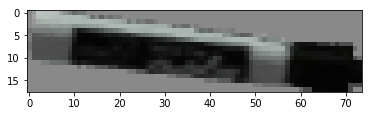

In [84]:
for ii in range (10):    
    obj_ind= -ii-40
    obj_name = ''.join(objs[obj_ind].split('_')[1:])
    obj_name
    try: 
        os.mkdir(path+obj_name) 
    except OSError as error: 
        print(error)  
    delete_object('spawned')
    move_base(1.25,1.0,np.pi)
    gaze_point(1.25,1.71,.6)
    x_gaz,y_gaz= world_2_gazebo(1.25,1.71)
    eu_i,eu_j,eu_k = 3.1416  ,0,0
    spawn_object('spawned',objs[obj_ind], x_gaz,  y_gaz,  0.41,eu_i,eu_j,eu_k )

    num_imgs=100
    for i in range(num_imgs):
        contador=len(os.listdir(path+'/'+obj_name))

        x_gaz,y_gaz= world_2_gazebo(1.25,1.71)
        eu_i,eu_j,eu_k = 3.1416 - i*(3.1416/num_imgs) ,0,0
        spawn_object('spawned',objs[obj_ind], x_gaz,  y_gaz,  0.45,eu_i,eu_j,eu_k )
        rospy.sleep(.1)
        res = service_client(req)
        cents,xyz, images=res_to_cents(res)
        shapes_ratio=[]

        for image in images:
            print(np.abs(image.shape[0]-image.shape[1]))
            shapes_ratio.append(np.abs(image.shape[0]-image.shape[1]))
        if len (images)!=0:
            plt.imshow(images[np.argmin(shapes_ratio)])
            contador=len(os.listdir(path+'/'+obj_name))
            cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[np.argmin(shapes_ratio)], cv2.COLOR_BGR2RGB))

        delete_object('spawned')
    num_imgs=100
    for i in range(num_imgs):
        contador=len(os.listdir(path+'/'+obj_name))

        x_gaz,y_gaz= world_2_gazebo(1.25,1.71)
        eu_i,eu_j,eu_k = 3.1416 - i*(3.1416/num_imgs) ,0,0
        spawn_object('spawned',objs[obj_ind], x_gaz,  y_gaz,  0.53,eu_i,eu_j,eu_k )
        rospy.sleep(.1)
        res = service_client(req)
        cents,xyz, images=res_to_cents(res)
        shapes_ratio=[]


        for image in images:
            print(np.abs(image.shape[0]-image.shape[1]))
            shapes_ratio.append(np.abs(image.shape[0]-image.shape[1]))
        if len(images)!=0:
            plt.imshow(images[np.argmin(shapes_ratio)])
            contador=len(os.listdir(path+'/'+obj_name))
            cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[np.argmin(shapes_ratio)], cv2.COLOR_BGR2RGB))

        delete_object('spawned')

In [83]:
ii

9

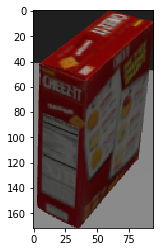

In [89]:
plt.imshow(images[np.argmin(shapes_ratio)])
contador=len(os.listdir(path+'/'+obj_name))
cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[np.argmin(shapes_ratio)], cv2.COLOR_BGR2RGB))
delete_object('spawned')

In [1]:
cents,xyz,images=seg_pca(lower=100,higher=40000,plt_images=True)


NameError: name 'seg_pca' is not defined

In [85]:
ii

5

In [65]:
arm.set_named_target('go')
arm.go()
head.set_named_targeta('neutral')
head.go()

AttributeError: 'MoveGroupCommander' object has no attribute 'set_named_targeta'

In [108]:
path='/home/oscar/Videos/videos_to_keras_train/'

objs[15].split('_')[1:]
obj_name = ''.join(objs[15].split('_')[1:])
obj_name
try: 
    os.mkdir(path+obj_name) 
except OSError as error: 
    print(error)  


[Errno 17] File exists: '/home/oscar/Videos/videos_to_keras_train/002masterchefcan'


True

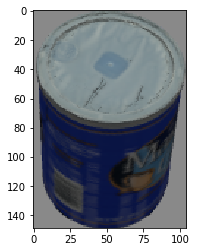

In [110]:
plt.imshow(images[0])
contador=len(os.listdir(path+'/'+obj_name))

cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))

In [77]:

def pad_digit_num(num,length):
    text_num=''
    for i in range(length -len(str(num))):
        text_num=text_num+'0'
    return(text_num+str(num))


In [79]:
contador=len(os.listdir(path+'/'+obj_name))
x_gaz,y_gaz= world_2_gazebo(1.5,1.61)
eu_i,eu_j,eu_k = 2,0.0,0.0
spawn_object('spawned',objs[15], x_gaz,  y_gaz,  0.51,eu_i,eu_j,eu_k )

cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[1], cv2.COLOR_BGR2RGB))
delete_object('spawned')

[INFO] [1639176405.867521, 382.221000]: Spawn: ycb_002_master_chef_can
[INFO] [1639176405.871339, 382.221000]: Spawn: [0.         0.         0.84147098 0.54030231]
[INFO] [1639176405.877488, 382.221000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639176405.892504, 382.235000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639176406.261470, 382.287000]: Spawn status: SpawnModel: Successfully spawned entity


[array([-0.48997826,  0.47688341, -0.33030321,  0.65069448]),
 array([-0.16005207, -0.64494008, -0.18783798,  0.72329283]),
 array([-0.40752737,  0.91122733, -0.05654474,  0.01972043])]

In [26]:
#cents, xyz=seg_pca()
#quats= pca_xyz(xyz)

cents= objs_depth_centroids
static_tf_publish(cents,quats)

NameError: name 'objs_depth_centroids' is not defined

In [76]:
centroids,xyz, images=seg_pca()
quats= pca_xyz(xyz)
static_tf_publish(centroids,quats)

('cX,cY', 73, 470)
[-0.38657558  0.40541616  0.98836577]
('cX,cY', 208, 439)
[-0.20475249  0.3305767   0.910819  ]
('cX,cY', 545, 430)
[0.46011162 0.37007445 1.1287674 ]
('cX,cY', 318, 326)
[-0.00164222  0.09490793  0.608489  ]
('cX,cY', 344, 50)
[ 0.15221651 -1.0081769   2.898817  ]
('cX,cY', 520, 9)
[ 1.2383422 -1.4023637  3.4012706]
('images[]', 0)
('images[]', 1)
('images[]', 2)
('images[]', 4)
('images[]', 5)


True

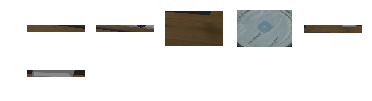

In [77]:
sub_plt=0
for image in images:
    
    sub_plt+=1
    ax = plt.subplot(5, 5, sub_plt )
    
    plt.imshow(image)
    plt.axis("off")

        

In [113]:
delete_object('spawned')

In [ ]:
tf.transformations.quaternion_from_euler(eu_i,eu_j,eu_k)

In [67]:
gaze_point( 1.45,1.7,  0.51)
arm.set_named_target('go')
arm.go()

('i am at', [1.504013154042386, 1.0881122082471295, 0.9671971453120808], 91.18959144177308)
('gaze goal', 1.45, 1.7, 0.51)
('relative to robot', (0.05401315404238605, -0.6118877917528704, -84.95540681911935))


True

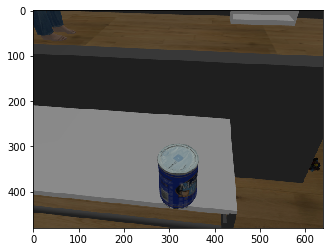

In [68]:
plt.imshow (rgbd.get_image())

('cX,cY', 76, 470)
[-0.3889382   0.40851146  0.9961041 ]
('cX,cY', 208, 438)
[-0.20423812  0.32901195  0.9134121 ]
('cX,cY', 545, 430)
[0.46086848 0.36852357 1.1306168 ]
('cX,cY', 319, 325)
[-5.3649477e-04  9.3556471e-02  6.1028546e-01]
('cX,cY', 302, 237)
[0.02285562 0.02727817 0.94996685]
('cX,cY', 343, 50)
[ 0.15232696 -1.0072949   2.8953772 ]
('cX,cY', 518, 8)
[ 1.2572143 -1.4013929  3.398889 ]


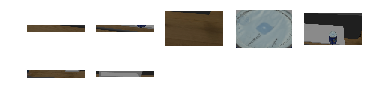

In [70]:
cents,xyz,images=seg_pca(lower=1000,higher=500000,plt_images=True)

In [71]:
res = service_client(req)

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
('Plane', 2, 'has', 1, 'objects')
('Plane', 3, 'has', 0, 'objects')
[array([3.56465416e-05, 1.00570345e-01, 6.18601648e-01]), array([-0.14591429,  0.28734213,  0.73829112])]


(array([[ 3.56465416e-05,  1.00570345e-01,  6.18601648e-01],
        [-1.45914289e-01,  2.87342130e-01,  7.38291115e-01]]),
 array([array([[-0.00875298,  0.06010379,  0.64700001],
        [-0.00641885,  0.06010379,  0.64700001],
        [-0.00873945,  0.06117615,  0.64600003],
        ...,
        [ 0.04290358,  0.20726657,  0.67000002],
        [ 0.04450717,  0.2091227 ,  0.67600006],
        [ 0.04303165,  0.20909745,  0.67200005]]),
        array([[-0.44399658,  0.26528969,  0.76800001],
        [-0.44122592,  0.26528969,  0.76800001],
        [-0.44284034,  0.26598054,  0.76600003],
        ...,
        [ 0.12097691,  0.29648745,  0.69500005],
        [ 0.12115098,  0.29816949,  0.69600004],
        [ 0.12149911,  0.30028537,  0.69800001]])], dtype=object))

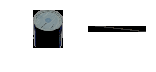

In [72]:
res_to_cents(res,plt_images=True)

In [53]:
path='/home/oscar/Videos/videos_to_keras_train/'
os.listdir(path)
objs[15].split('_')[1:]
obj_name = ''.join(objs[15].split('_')[1:])
obj_name

'002masterchefcan'

In [114]:
try: 
    os.mkdir(path+obj_name) 
except OSError as error: 
    print(error)  
cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',img_roi)

[Errno 17] File exists: '/home/oscar/Videos/videos_to_keras_train/002masterchefcan'


NameError: name 'img_roi' is not defined

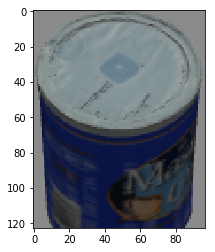

In [101]:
plt.imshow(images[0])

In [74]:
res_to_cents(res)

('Plane', 0, 'has', 3, 'objects')
('Plane', 1, 'has', 0, 'objects')
('Plane', 2, 'has', 0, 'objects')
('Plane', 3, 'has', 0, 'objects')
[array([ 0.45296013, -0.04971411,  0.96959864]), array([-4.17267404e-05,  1.00913426e-01,  6.18089280e-01]), array([-0.14664006,  0.28748951,  0.73805637])]


(array([[ 4.52960134e-01, -4.97141067e-02,  9.69598645e-01],
        [-4.17267404e-05,  1.00913426e-01,  6.18089280e-01],
        [-1.46640063e-01,  2.87489507e-01,  7.38056373e-01]]),
 array([array([[ 0.41473159, -0.07013206,  0.96000004],
        [ 0.4177593 , -0.07005901,  0.95900005],
        [ 0.41516361, -0.06847166,  0.96100003],
        ...,
        [ 0.49080631, -0.03260293,  0.97700006],
        [ 0.49130866, -0.03087218,  0.97800004],
        [ 0.49181104, -0.02913782,  0.97900003]]),
        array([[-0.00758592,  0.06010379,  0.64700001],
        [-0.00525179,  0.06010379,  0.64700001],
        [-0.00757419,  0.06117615,  0.64600003],
        ...,
        [ 0.04290358,  0.20726657,  0.67000002],
        [ 0.04450717,  0.2091227 ,  0.67600006],
        [ 0.04303165,  0.20909745,  0.67200005]]),
        array([[-0.44399658,  0.26528969,  0.76800001],
        [-0.44122592,  0.26528969,  0.76800001],
        [-0.44284034,  0.26598054,  0.76600003],
        ...,
        [ 0.1208

('Plane', 0, 'has', 3, 'objects')
('Plane', 1, 'has', 0, 'objects')
('Plane', 2, 'has', 0, 'objects')
('Plane', 3, 'has', 0, 'objects')
[array([ 0.45296013, -0.04971411,  0.96959864]), array([-4.17267404e-05,  1.00913426e-01,  6.18089280e-01]), array([-0.14664006,  0.28748951,  0.73805637])]


ValueError: need more than 2 values to unpack

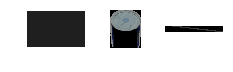

In [75]:
cents, xyz,images=res_to_cents(res,True)

In [ ]:
quats=pca_xyz(xyz)

In [ ]:
static_tf_publish(cents,quats,'end')

In [ ]:
cents,xyz,images=seg_pca(lower=100,higher=10000,plt_images=True)

In [ ]:
move_base(2,1,np.pi)

In [ ]:
gaze_point(1,1,.1)
arm.set_named_target('go')
arm.go()

In [ ]:
cents,xyz,images=seg_pca(lower=100,higher=10000,plt_images=True)

In [ ]:
x_gaz,y_gaz= world_2_gazebo(1,1)
eu_i,eu_j,eu_k = .5*np.pi,0,0
spawn_object('spawned',objs[-13], x_gaz,  y_gaz,  0.6,eu_i,eu_j,eu_k )


In [ ]:
cents,xyz,images=seg_pca(lower=100,higher=40000,plt_images=True)
quats=pca_xyz(xyz)
static_tf_publish(cents,quats,'at 2,1')

In [ ]:
move_base(1.5,.5,np.pi)

In [ ]:
gaze_point(1,1,.1)
arm.set_named_target('go')
arm.go()

In [ ]:
cents,xyz,images=seg_pca(lower=100,higher=40000,plt_images=True)
quats=pca_xyz(xyz)
static_tf_publish(cents,quats,'at 1.5,.5')

In [ ]:
move_base(1.5,.5,0)

In [ ]:
gaze_point(1,1,.1)
arm.set_named_target('go')
arm.go()

('cX,cY', 301, 476)
[-0.00747844  0.21911964  0.5158296 ]
('cX,cY', 75, 468)
[-0.35996425  0.37436187  0.92190623]
('cX,cY', 290, 444)
[-0.16598909  0.35188416  0.93478006]
('cX,cY', 443, 285)
[0.14822534 0.00063732 0.6164476 ]
('cX,cY', 411, 326)
nan
('cX,cY', 454, 232)


/home/oscar/.local/lib/python2.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice.
/home/oscar/.local/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[ 0.20696914 -0.04515864  0.6708069 ]
('cX,cY', 613, 1)
[ 1.4960889 -1.2877432  3.0058494]
('cX,cY', 105, 3)
[-1.0369995 -1.1491358  2.699405 ]
('cX,cY', 17, 5)
[-1.5290263 -1.1761056  2.8287847]


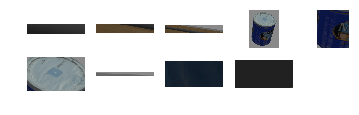

In [147]:
cents,xyz,images=seg_pca(lower=100,higher=40000,plt_images=True)



In [22]:
images_test= np.load('/home/roboworks/Codes/TensorFLow/imgs_test.npy',allow_pickle=True)


In [26]:
img=tensorflow.image.resize(images_test[0],(300,300))

In [28]:
test_imgs=np.zeros((1,300,300,3))
for image in images_test:
    img=tensorflow.image.resize(image,(300,300))
    new=np.expand_dims(img.numpy(),axis=0)
    test_imgs=np.concatenate((test_imgs,new))
    
    

In [29]:
test_imgs.shape

(3, 300, 300, 3)

In [34]:
np.argmax(model.predict(test_imgs),axis=1)


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv2d/Conv2D (defined at <ipython-input-32-8460c4ba5c0a>:1) ]] [Op:__inference_distributed_function_799]

Function call stack:
distributed_function


In [35]:
tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)

NameError: name 'physical_devices' is not defined

In [30]:
head.set_named_target('neutral')
head.go()

True

In [37]:
points.shape

(480, 640)

In [36]:
points

array([[(        nan,        nan,       nan, 1.6410822e-38),
        (        nan,        nan,       nan, 1.6410822e-38),
        (        nan,        nan,       nan, 1.6410822e-38), ...,
        (        nan,        nan,       nan, 1.6410822e-38),
        (        nan,        nan,       nan, 1.6410822e-38),
        (        nan,        nan,       nan, 1.6410822e-38)],
       [(        nan,        nan,       nan, 1.6410822e-38),
        (        nan,        nan,       nan, 1.6410822e-38),
        (        nan,        nan,       nan, 1.6410822e-38), ...,
        (        nan,        nan,       nan, 1.6410822e-38),
        (        nan,        nan,       nan, 1.6410822e-38),
        (        nan,        nan,       nan, 1.6410822e-38)],
       [(        nan,        nan,       nan, 1.6410822e-38),
        (        nan,        nan,       nan, 1.6410822e-38),
        (        nan,        nan,       nan, 1.6410822e-38), ...,
        (        nan,        nan,       nan, 1.6410822e-38),
       

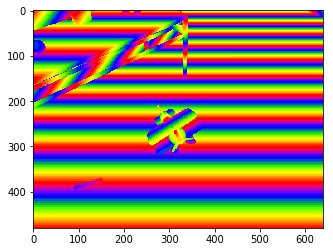

In [28]:
plt.imshow(points['z'], cmap='prism')

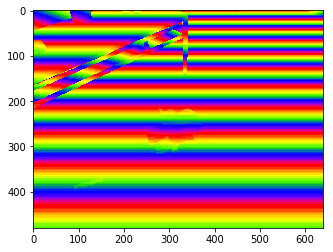

In [26]:
points = rgbd.get_points()
plt.imshow(points['y'], cmap='prism')

In [29]:
pose,  quat =listener.lookupTransform('head_rgbd_sensor_link', 'map',rospy.Time(0))
pose,tf.transformations.euler_from_quaternion(quat)

([0.07508758241738461, 1.35594471678447, 0.0034866583573299192],
 (2.529021955048501, -0.5257563801537658, -0.6201566785926279))

In [71]:
gaze_point(0.61,0.61,.05)

('i am at', [-0.18564783114879474, 0.6646564080329085, 1.0171895373751214], 15.970654795310391)
('gaze goal', 0.61, 0.61, 0.05)
('relative to robot', (-0.7956478311487947, 0.0546564080329085, 176.07028460076393))


True

In [30]:
arm.set_named_target('neutral')
arm.go()
head.set_named_target('neutral')
head.go()

True

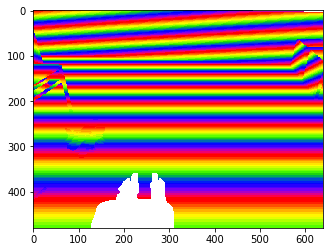

In [54]:
points = rgbd.get_points()
plt.imshow(points['y'], cmap='prism')

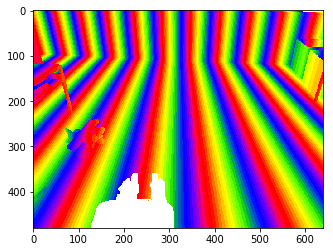

In [55]:
points = rgbd.get_points()
plt.imshow(points['x'], cmap='prism')

In [56]:
ys=points['y']
xs=points['x']
zs=points['z']

In [58]:
au=ys[-11:-1,400]
au

array([0.47169933, 0.47289407, 0.47408444, 0.4752705 , 0.47645235,
       0.47762987, 0.47880316, 0.4799723 , 0.4811372 , 0.4822979 ],
      dtype=float32)

In [59]:
ys[-1,390:400]

array([0.48345414, 0.48345414, 0.4834542 , 0.48345426, 0.48345426,
       0.4834543 , 0.4834543 , 0.48345435, 0.4834544 , 0.4834544 ],
      dtype=float32)

In [60]:
head_val=head.get_current_joint_values()
#head_val[0]=np.deg2rad(0)
head_val[1]=np.deg2rad(-30)

head.go(head_val)

True

In [68]:
au[0]-au[-1]

-0.01059857

In [62]:
au[4]-au[5]

-0.0011775196

In [63]:
ys[-1,390:400]

array([0.48345414, 0.48345414, 0.4834542 , 0.48345426, 0.48345426,
       0.4834543 , 0.4834543 , 0.48345435, 0.4834544 , 0.4834544 ],
      dtype=float32)

In [65]:
bu=xs[-1,390:400]

In [67]:
bu[0]-bu[-1]

-0.018167466